## Import of utils 

In [2]:
# Create folder 
from utils.create_folder import create_simulation_folder
results_dir = create_simulation_folder()

[INFO] Simulation folder created: results/2025-12-03_08-44-08


In [3]:
# =================================
# Global reproducibility seed
# =================================
GLOBAL_SEED = 42

import os
import random
import numpy as np

random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
os.environ["PYTHONHASHSEED"] = str(GLOBAL_SEED)

In [4]:
import re

def safe_filename(text):
    """Convert any string into a safe filename."""
    text = text.lower()
    text = text.replace(" ", "_")
    text = re.sub(r"[^a-z0-9_\-]", "", text)  # keep only alphanum, _, -
    return text


## Topology

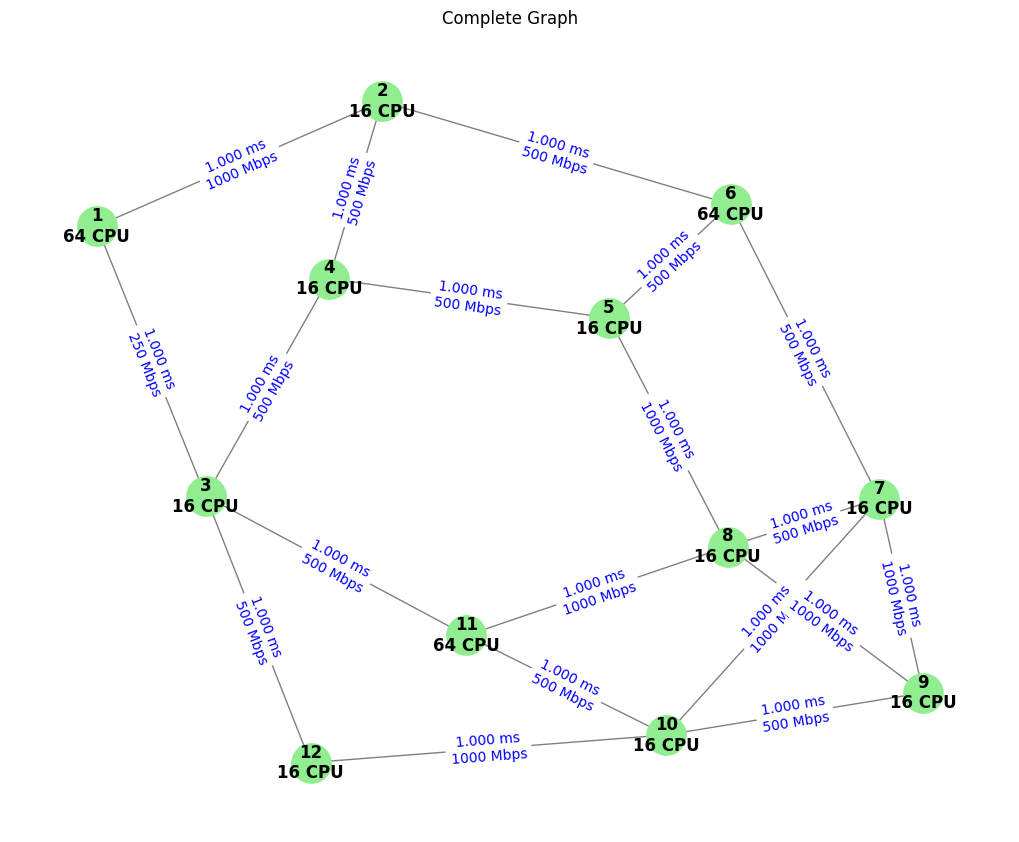

In [5]:
from utils.topology import topology_bayern, draw_graph, topologie_finlande, topology_brazil
from utils.generate_slices import generate_random_slices
from milp.topology_to_instance import build_instance_from_topology
from milp.solver_gurobi import solve_gurobi      
from milp.adapter import MILPResultAdapterGurobi

import pandas as pd

# === Topology ===
G = topologie_finlande()

draw_graph(G)


# Scalability

In [6]:
# ============================
# Imports (clean and complete)
# ============================

import os
import time
import random
import numpy as np
import networkx as nx
import pandas as pd
from copy import deepcopy
from datetime import datetime
import re

# --- Safe filename function ---
def safe_filename(text):
    """Convert any string into a safe filename: no accents, spaces, or special chars."""
    text = text.lower()
    text = text.replace(" ", "_")
    text = re.sub(r"[^a-z0-9_\-]", "", text)
    return text

# --- Global reproducibility seed ---
GLOBAL_SEED = 42
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
os.environ["PYTHONHASHSEED"] = str(GLOBAL_SEED)

# --- MILP modules ---
from milp.create_instance import create_instance
from milp.solver_gurobi import solve_gurobi
from milp.adapter import MILPResultAdapterGurobi

# --- Topologies ---
from utils.topology import topologie_finlande, topology_brazil

# --- Slice generation ---
from utils.generate_slices import generate_random_slices

# --- Graph generation ---
from utils.generate_graphs import plot_all_routes, plot_cpu_usage

# --- Heuristics ---
from heuristics.a_star import run_astar
from heuristics.run_abo_full_batch import run_abo_full_batch
from heuristics.run_fabo_full_batch import run_fabo_full_batch
from heuristics.best_fit import run_best_fit
from heuristics.first_fit import run_first_fit
from heuristics.a_star_energy_aware import energy_aware_astar

# --- Metrics ---
from utils.metrics import (
    count_accepted_slices,
    compute_energy_new,
    compute_total_bandwidth,
    compute_total_latency,
)

# ============================
# Directories for results
# ============================

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
results_dir = os.path.join("./results", safe_filename(timestamp))
os.makedirs(results_dir, exist_ok=True)

routes_dir = os.path.join(results_dir, "routes")
cpu_dir = os.path.join(results_dir, "cpu_usage")
os.makedirs(routes_dir, exist_ok=True)
os.makedirs(cpu_dir, exist_ok=True)

print(f"[INFO] Results will be saved under: {results_dir}")

# --- Global MILP / experiment parameters ---
MILP_TIME_LIMIT = 300
ENTRY = 6
MAX_MILP_SLICES = 128
MAX_MILP_VNFS_TOTAL = 512

# --- Topology ---
G = topologie_finlande()
ENTRY = 6
pos = nx.spring_layout(G, seed=GLOBAL_SEED)

# --- VNF profiles ---
vnf_profiles = [
    {"cpu": 2, "throughput": 40, "latency": 120},
    {"cpu": 4, "throughput": 50, "latency": 180},
    {"cpu": 6, "throughput": 60, "latency": 200},
    {"cpu": 8, "throughput": 75, "latency": 250},
]

# --- Base capacities ---
node_capacity_base = {n: G.nodes[n]["cpu"] for n in G.nodes}
link_capacity_base = {(u, v): G[u][v]["bandwidth"] for u, v in G.edges}
link_capacity_base.update({(v, u): G[u][v]["bandwidth"] for u, v in G.edges})
link_latency = {(u, v): G[u][v]["latency"] for u, v in G.edges}
link_latency.update({(v, u): G[u][v]["latency"] for u, v in G.edges})

# --- Parameter grid ---
param_grid = {
    "num_slices": [6, 8, 10, 12, 16, 18, 20, 32, 64, 128],
    "num_vnfs_per_slice": [2, 3, 4],
    "seed": [1, 2, 3, 4, 5],
}

max_slices = max(param_grid["num_slices"])

# IMPORTANT: reset records before the main loop
records = []

try:
    # ------------------------------------------------------------------
    # Main experiment loop with a fixed pool of slices per (vnf, seed)
    # ------------------------------------------------------------------
    for num_vnfs in param_grid["num_vnfs_per_slice"]:
        for seed in param_grid["seed"]:
            # Fix per-(num_vnfs, seed) randomness
            random.seed(seed)
            np.random.seed(seed)

            print(f"\n[INFO] === Pre-generating slice pool: max_slices={max_slices}, "
                  f"VNFs={num_vnfs}, seed={seed} ===")

            slice_pool = generate_random_slices(
                G,
                vnf_profiles,
                num_slices=max_slices,
                num_vnfs_per_slice=num_vnfs,
                entry=ENTRY,
            )

            if len(slice_pool) < max_slices:
                print(f"[WARN] slice_pool has only {len(slice_pool)} entries (expected {max_slices}).")

            # Sweep number of slices for this (num_vnfs, seed)
            for num_slices in param_grid["num_slices"]:
                total_vnfs = num_slices * num_vnfs

                print(f"\n[INFO] === Running Load Test: {num_slices} slices × "
                      f"{num_vnfs} VNFs (total={total_vnfs}), seed={seed} ===")

                # Use the first num_slices from the fixed pool
                slices = deepcopy(slice_pool[:num_slices])
                method_results = {}
                method_times = {}

                # --- Heuristics ---
                for name, func, args in [
                    ("A*", run_astar, (G, slices, node_capacity_base, link_capacity_base)),
                    ("ABO", run_abo_full_batch, (G, slices, node_capacity_base, link_latency, link_capacity_base)),
                    ("FABO", run_fabo_full_batch, (G, slices, node_capacity_base, link_latency, link_capacity_base)),
                    ("Best Fit", run_best_fit, (G, slices, node_capacity_base, link_capacity_base, link_latency)),
                    ("First Fit", run_first_fit, (G, slices, node_capacity_base, link_capacity_base, link_latency)),
                    ("Energy-Aware A*", energy_aware_astar,
                     (G, slices, node_capacity_base, link_capacity_base, 0.6, 0.4)),
                ]:
                    start = time.time()
                    try:
                        df_res, res_list = func(*args)
                        method_results[name] = res_list
                    except Exception as e:
                        print(f"[ERROR] {name} failed: {e}")
                        method_results[name] = []
                    method_times[name] = time.time() - start

                # --- MILP (optional, limited by size) ---
                if num_slices <= MAX_MILP_SLICES and total_vnfs <= MAX_MILP_VNFS_TOTAL:
                    try:
                        print(f"\n[INFO][MILP] Running Gurobi MILP…")
                        start = time.time()
                        instance = create_instance(G, slices)
                        instance.entry_node = ENTRY

                        res = solve_gurobi(instance, msg=False, time_limit=MILP_TIME_LIMIT)
                        method_results["MILP_Gurobi"] = [MILPResultAdapterGurobi(res, instance)]
                        method_times["MILP_Gurobi"] = time.time() - start
                    except Exception as e:
                        print(f"[ERROR][MILP] Failed: {e}")
                        method_results["MILP_Gurobi"] = []
                        method_times["MILP_Gurobi"] = None

                # ----------------------------------------
                # Per-scenario visualizations
                # ----------------------------------------
                for method_name, result_list in method_results.items():
                    if not result_list:
                        continue

                    safe_img_name = safe_filename(
                        f"{method_name}_slices{num_slices}_vnfs{num_vnfs}_seed{seed}"
                    )

                    plot_all_routes(
                        G,
                        result_list,
                        title="All routed paths",
                        results_dir=routes_dir,
                        num_slices=num_slices,
                        num_vnfs_per_slice=num_vnfs,
                        seed=seed,
                        method_name=safe_img_name,
                        # pos=pos,  # uncomment if function supports fixed layout
                    )

                # CPU usage plot (all methods for this scenario)
                plot_cpu_usage(
                    G,
                    slices,
                    method_results,
                    results_dir=cpu_dir,
                    num_slices=num_slices,
                    num_vnfs_per_slice=num_vnfs,
                    seed=seed,
                )

                # --- Metrics ---
                for method_name, result_list in method_results.items():
                    if not result_list:
                        continue
                    try:
                        accepted = count_accepted_slices(result_list, slices)
                        total_energy = compute_energy_new(
                            result_list, slices, node_capacity_base, link_capacity_base
                        )
                        total_bw = sum(b for b in compute_total_bandwidth(result_list, slices) if b)
                        total_lat = sum(l for l in compute_total_latency(result_list, link_latency) if l)

                        records.append({
                            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                            "num_slices": num_slices,
                            "num_vnfs_per_slice": num_vnfs,
                            "total_vnfs": total_vnfs,
                            "seed": seed,
                            "method": method_name,
                            "accepted": accepted,
                            "total_energy": total_energy,
                            "total_bandwidth": total_bw,
                            "total_latency": total_lat,
                            "runtime_sec": method_times[method_name],
                        })
                    except Exception as e:
                        print(f"[ERROR] Metrics failed for {method_name}, "
                              f"slices={num_slices}, vnfs={num_vnfs}, seed={seed}: {e}")

finally:
    # --- Save results even if something failed ---
    df_results = pd.DataFrame(records)

    if not df_results.empty:
        dup = df_results.groupby(["method", "num_slices", "num_vnfs_per_slice", "seed"]).size()
        print("[CHECK] Max repetitions:", dup.max())
    else:
        print("[WARN] df_results is empty, nothing to group.")

    output_path = os.path.join(results_dir, "scalability_results.csv")
    df_results.to_csv(output_path, index=False)
    print(f"\n[INFO] Results saved to {output_path}")
    print(f"[INFO] records generated: {len(records)}")
    print(f"[INFO] CSV exists? {os.path.exists(output_path)}")


[INFO] Results will be saved under: ./results/2025-12-03_08-44-43

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=2, seed=1 ===

[INFO] === Running Load Test: 6 slices × 2 VNFs (total=12), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 6 accepted.


[

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices6_vnfs2_seed1_s6_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices6_vnfs2_seed1_s6_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices6_vnfs2_seed1_s6_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices6_vnfs2_seed1_s6_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices6_vnfs2_seed1_s6_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices6_vnfs2_seed1_s6_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices6_vnfs2_seed1_s6_v2_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s6_v2_seed1.png

[INFO] === Running Load Test: 8 slices × 2 VNFs (total=16), seed=1 ===

[INFO][A*] 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices8_vnfs2_seed1_s8_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices8_vnfs2_seed1_s8_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices8_vnfs2_seed1_s8_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices8_vnfs2_seed1_s8_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices8_vnfs2_seed1_s8_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices8_vnfs2_seed1_s8_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices8_vnfs2_seed1_s8_v2_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s8_v2_seed1.png

[INFO] === Running Load Test: 10 slices × 2 VNFs (total=20), seed=1 ===

[INFO][A*]

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices10_vnfs2_seed1_s10_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices10_vnfs2_seed1_s10_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices10_vnfs2_seed1_s10_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices10_vnfs2_seed1_s10_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices10_vnfs2_seed1_s10_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices10_vnfs2_seed1_s10_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices10_vnfs2_seed1_s10_v2_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s10_v2_seed1.png

[INFO] === Running Load Test: 12 slices × 2 VNFs (total=24), seed=1 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices12_vnfs2_seed1_s12_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices12_vnfs2_seed1_s12_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices12_vnfs2_seed1_s12_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices12_vnfs2_seed1_s12_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices12_vnfs2_seed1_s12_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices12_vnfs2_seed1_s12_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices12_vnfs2_seed1_s12_v2_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s12_v2_seed1.png

[INFO] === Running Load Test: 16 slices × 2 VNFs (total=32), seed=1 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices16_vnfs2_seed1_s16_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices16_vnfs2_seed1_s16_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices16_vnfs2_seed1_s16_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices16_vnfs2_seed1_s16_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices16_vnfs2_seed1_s16_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices16_vnfs2_seed1_s16_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices16_vnfs2_seed1_s16_v2_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s16_v2_seed1.png

[INFO] === Running Load Test: 18 slices × 2 VNFs (total=36), seed=1 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices18_vnfs2_seed1_s18_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices18_vnfs2_seed1_s18_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices18_vnfs2_seed1_s18_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices18_vnfs2_seed1_s18_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices18_vnfs2_seed1_s18_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices18_vnfs2_seed1_s18_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices18_vnfs2_seed1_s18_v2_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s18_v2_seed1.png

[INFO] === Running Load Test: 20 slices × 2 VNFs (total=40), seed=1 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices20_vnfs2_seed1_s20_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices20_vnfs2_seed1_s20_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices20_vnfs2_seed1_s20_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices20_vnfs2_seed1_s20_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices20_vnfs2_seed1_s20_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices20_vnfs2_seed1_s20_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices20_vnfs2_seed1_s20_v2_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s20_v2_seed1.png

[INFO] === Running Load Test: 32 slices × 2 VNFs (total=64), seed=1 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices32_vnfs2_seed1_s32_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices32_vnfs2_seed1_s32_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices32_vnfs2_seed1_s32_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices32_vnfs2_seed1_s32_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices32_vnfs2_seed1_s32_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices32_vnfs2_seed1_s32_v2_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s32_v2_seed1.png

[INFO] === Running Load Test: 64 slices × 2 VNFs (total=128), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slic

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices64_vnfs2_seed1_s64_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices64_vnfs2_seed1_s64_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices64_vnfs2_seed1_s64_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices64_vnfs2_seed1_s64_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices64_vnfs2_seed1_s64_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices64_vnfs2_seed1_s64_v2_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s64_v2_seed1.png

[INFO] === Running Load Test: 128 slices × 2 VNFs (total=256), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Sli

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices128_vnfs2_seed1_s128_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices128_vnfs2_seed1_s128_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices128_vnfs2_seed1_s128_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices128_vnfs2_seed1_s128_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices128_vnfs2_seed1_s128_v2_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices128_vnfs2_seed1_s128_v2_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s128_v2_seed1.png

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=2, seed=2 ===

[INFO] === Running Load Test: 6 slices × 2 VNFs (total=12), seed=2 ===

[INFO][A*] === Solving slice 1

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices6_vnfs2_seed2_s6_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices6_vnfs2_seed2_s6_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices6_vnfs2_seed2_s6_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices6_vnfs2_seed2_s6_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices6_vnfs2_seed2_s6_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices6_vnfs2_seed2_s6_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices6_vnfs2_seed2_s6_v2_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s6_v2_seed2.png

[INFO] === Running Load Test: 8 slices × 2 VNFs (total=16), seed=2 ===

[INFO][A*] 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices8_vnfs2_seed2_s8_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices8_vnfs2_seed2_s8_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices8_vnfs2_seed2_s8_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices8_vnfs2_seed2_s8_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices8_vnfs2_seed2_s8_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices8_vnfs2_seed2_s8_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices8_vnfs2_seed2_s8_v2_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s8_v2_seed2.png

[INFO] === Running Load Test: 10 slices × 2 VNFs (total=20), seed=2 ===

[INFO][A*]

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices10_vnfs2_seed2_s10_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices10_vnfs2_seed2_s10_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices10_vnfs2_seed2_s10_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices10_vnfs2_seed2_s10_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices10_vnfs2_seed2_s10_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices10_vnfs2_seed2_s10_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices10_vnfs2_seed2_s10_v2_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s10_v2_seed2.png

[INFO] === Running Load Test: 12 slices × 2 VNFs (total=24), seed=2 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices12_vnfs2_seed2_s12_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices12_vnfs2_seed2_s12_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices12_vnfs2_seed2_s12_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices12_vnfs2_seed2_s12_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices12_vnfs2_seed2_s12_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices12_vnfs2_seed2_s12_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices12_vnfs2_seed2_s12_v2_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s12_v2_seed2.png

[INFO] === Running Load Test: 16 slices × 2 VNFs (total=32), seed=2 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices16_vnfs2_seed2_s16_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices16_vnfs2_seed2_s16_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices16_vnfs2_seed2_s16_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices16_vnfs2_seed2_s16_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices16_vnfs2_seed2_s16_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices16_vnfs2_seed2_s16_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices16_vnfs2_seed2_s16_v2_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s16_v2_seed2.png

[INFO] === Running Load Test: 18 slices × 2 VNFs (total=36), seed=2 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices18_vnfs2_seed2_s18_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices18_vnfs2_seed2_s18_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices18_vnfs2_seed2_s18_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices18_vnfs2_seed2_s18_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices18_vnfs2_seed2_s18_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices18_vnfs2_seed2_s18_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices18_vnfs2_seed2_s18_v2_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s18_v2_seed2.png

[INFO] === Running Load Test: 20 slices × 2 VNFs (total=40), seed=2 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices20_vnfs2_seed2_s20_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices20_vnfs2_seed2_s20_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices20_vnfs2_seed2_s20_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices20_vnfs2_seed2_s20_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices20_vnfs2_seed2_s20_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices20_vnfs2_seed2_s20_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices20_vnfs2_seed2_s20_v2_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s20_v2_seed2.png

[INFO] === Running Load Test: 32 slices × 2 VNFs (total=64), seed=2 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices32_vnfs2_seed2_s32_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices32_vnfs2_seed2_s32_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices32_vnfs2_seed2_s32_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices32_vnfs2_seed2_s32_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices32_vnfs2_seed2_s32_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices32_vnfs2_seed2_s32_v2_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s32_v2_seed2.png

[INFO] === Running Load Test: 64 slices × 2 VNFs (total=128), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slic

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices64_vnfs2_seed2_s64_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices64_vnfs2_seed2_s64_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices64_vnfs2_seed2_s64_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices64_vnfs2_seed2_s64_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices64_vnfs2_seed2_s64_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices64_vnfs2_seed2_s64_v2_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s64_v2_seed2.png

[INFO] === Running Load Test: 128 slices × 2 VNFs (total=256), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Sli

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices128_vnfs2_seed2_s128_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices128_vnfs2_seed2_s128_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices128_vnfs2_seed2_s128_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices128_vnfs2_seed2_s128_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices128_vnfs2_seed2_s128_v2_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices128_vnfs2_seed2_s128_v2_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s128_v2_seed2.png

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=2, seed=3 ===

[INFO] === Running Load Test: 6 slices × 2 VNFs (total=12), seed=3 ===

[INFO][A*] === Solving slice 1

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices6_vnfs2_seed3_s6_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices6_vnfs2_seed3_s6_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices6_vnfs2_seed3_s6_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices6_vnfs2_seed3_s6_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices6_vnfs2_seed3_s6_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices6_vnfs2_seed3_s6_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices6_vnfs2_seed3_s6_v2_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s6_v2_seed3.png

[INFO] === Running Load Test: 8 slices × 2 VNFs (total=16), seed=3 ===

[INFO][A*] 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices8_vnfs2_seed3_s8_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices8_vnfs2_seed3_s8_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices8_vnfs2_seed3_s8_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices8_vnfs2_seed3_s8_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices8_vnfs2_seed3_s8_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices8_vnfs2_seed3_s8_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices8_vnfs2_seed3_s8_v2_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s8_v2_seed3.png

[INFO] === Running Load Test: 10 slices × 2 VNFs (total=20), seed=3 ===

[INFO][A*]

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices10_vnfs2_seed3_s10_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices10_vnfs2_seed3_s10_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices10_vnfs2_seed3_s10_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices10_vnfs2_seed3_s10_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices10_vnfs2_seed3_s10_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices10_vnfs2_seed3_s10_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices10_vnfs2_seed3_s10_v2_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s10_v2_seed3.png

[INFO] === Running Load Test: 12 slices × 2 VNFs (total=24), seed=3 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices12_vnfs2_seed3_s12_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices12_vnfs2_seed3_s12_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices12_vnfs2_seed3_s12_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices12_vnfs2_seed3_s12_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices12_vnfs2_seed3_s12_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices12_vnfs2_seed3_s12_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices12_vnfs2_seed3_s12_v2_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s12_v2_seed3.png

[INFO] === Running Load Test: 16 slices × 2 VNFs (total=32), seed=3 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices16_vnfs2_seed3_s16_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices16_vnfs2_seed3_s16_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices16_vnfs2_seed3_s16_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices16_vnfs2_seed3_s16_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices16_vnfs2_seed3_s16_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices16_vnfs2_seed3_s16_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices16_vnfs2_seed3_s16_v2_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s16_v2_seed3.png

[INFO] === Running Load Test: 18 slices × 2 VNFs (total=36), seed=3 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices18_vnfs2_seed3_s18_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices18_vnfs2_seed3_s18_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices18_vnfs2_seed3_s18_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices18_vnfs2_seed3_s18_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices18_vnfs2_seed3_s18_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices18_vnfs2_seed3_s18_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices18_vnfs2_seed3_s18_v2_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s18_v2_seed3.png

[INFO] === Running Load Test: 20 slices × 2 VNFs (total=40), seed=3 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices20_vnfs2_seed3_s20_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices20_vnfs2_seed3_s20_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices20_vnfs2_seed3_s20_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices20_vnfs2_seed3_s20_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices20_vnfs2_seed3_s20_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices20_vnfs2_seed3_s20_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices20_vnfs2_seed3_s20_v2_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s20_v2_seed3.png

[INFO] === Running Load Test: 32 slices × 2 VNFs (total=64), seed=3 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices32_vnfs2_seed3_s32_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices32_vnfs2_seed3_s32_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices32_vnfs2_seed3_s32_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices32_vnfs2_seed3_s32_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices32_vnfs2_seed3_s32_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices32_vnfs2_seed3_s32_v2_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s32_v2_seed3.png

[INFO] === Running Load Test: 64 slices × 2 VNFs (total=128), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slic

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices64_vnfs2_seed3_s64_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices64_vnfs2_seed3_s64_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices64_vnfs2_seed3_s64_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices64_vnfs2_seed3_s64_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices64_vnfs2_seed3_s64_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices64_vnfs2_seed3_s64_v2_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s64_v2_seed3.png

[INFO] === Running Load Test: 128 slices × 2 VNFs (total=256), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Sli

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices128_vnfs2_seed3_s128_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices128_vnfs2_seed3_s128_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices128_vnfs2_seed3_s128_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices128_vnfs2_seed3_s128_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices128_vnfs2_seed3_s128_v2_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices128_vnfs2_seed3_s128_v2_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s128_v2_seed3.png

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=2, seed=4 ===

[INFO] === Running Load Test: 6 slices × 2 VNFs (total=12), seed=4 ===

[INFO][A*] === Solving slice 1

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices6_vnfs2_seed4_s6_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices6_vnfs2_seed4_s6_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices6_vnfs2_seed4_s6_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices6_vnfs2_seed4_s6_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices6_vnfs2_seed4_s6_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices6_vnfs2_seed4_s6_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices6_vnfs2_seed4_s6_v2_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s6_v2_seed4.png

[INFO] === Running Load Test: 8 slices × 2 VNFs (total=16), seed=4 ===

[INFO][A*] 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices8_vnfs2_seed4_s8_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices8_vnfs2_seed4_s8_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices8_vnfs2_seed4_s8_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices8_vnfs2_seed4_s8_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices8_vnfs2_seed4_s8_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices8_vnfs2_seed4_s8_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices8_vnfs2_seed4_s8_v2_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s8_v2_seed4.png

[INFO] === Running Load Test: 10 slices × 2 VNFs (total=20), seed=4 ===

[INFO][A*]

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices10_vnfs2_seed4_s10_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices10_vnfs2_seed4_s10_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices10_vnfs2_seed4_s10_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices10_vnfs2_seed4_s10_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices10_vnfs2_seed4_s10_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices10_vnfs2_seed4_s10_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices10_vnfs2_seed4_s10_v2_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s10_v2_seed4.png

[INFO] === Running Load Test: 12 slices × 2 VNFs (total=24), seed=4 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices12_vnfs2_seed4_s12_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices12_vnfs2_seed4_s12_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices12_vnfs2_seed4_s12_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices12_vnfs2_seed4_s12_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices12_vnfs2_seed4_s12_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices12_vnfs2_seed4_s12_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices12_vnfs2_seed4_s12_v2_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s12_v2_seed4.png

[INFO] === Running Load Test: 16 slices × 2 VNFs (total=32), seed=4 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices16_vnfs2_seed4_s16_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices16_vnfs2_seed4_s16_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices16_vnfs2_seed4_s16_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices16_vnfs2_seed4_s16_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices16_vnfs2_seed4_s16_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices16_vnfs2_seed4_s16_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices16_vnfs2_seed4_s16_v2_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s16_v2_seed4.png

[INFO] === Running Load Test: 18 slices × 2 VNFs (total=36), seed=4 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices18_vnfs2_seed4_s18_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices18_vnfs2_seed4_s18_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices18_vnfs2_seed4_s18_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices18_vnfs2_seed4_s18_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices18_vnfs2_seed4_s18_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices18_vnfs2_seed4_s18_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices18_vnfs2_seed4_s18_v2_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s18_v2_seed4.png

[INFO] === Running Load Test: 20 slices × 2 VNFs (total=40), seed=4 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices20_vnfs2_seed4_s20_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices20_vnfs2_seed4_s20_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices20_vnfs2_seed4_s20_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices20_vnfs2_seed4_s20_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices20_vnfs2_seed4_s20_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices20_vnfs2_seed4_s20_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices20_vnfs2_seed4_s20_v2_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s20_v2_seed4.png

[INFO] === Running Load Test: 32 slices × 2 VNFs (total=64), seed=4 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices32_vnfs2_seed4_s32_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices32_vnfs2_seed4_s32_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices32_vnfs2_seed4_s32_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices32_vnfs2_seed4_s32_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices32_vnfs2_seed4_s32_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices32_vnfs2_seed4_s32_v2_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s32_v2_seed4.png

[INFO] === Running Load Test: 64 slices × 2 VNFs (total=128), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slic

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices64_vnfs2_seed4_s64_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices64_vnfs2_seed4_s64_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices64_vnfs2_seed4_s64_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices64_vnfs2_seed4_s64_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices64_vnfs2_seed4_s64_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices64_vnfs2_seed4_s64_v2_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s64_v2_seed4.png

[INFO] === Running Load Test: 128 slices × 2 VNFs (total=256), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Sli

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices128_vnfs2_seed4_s128_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices128_vnfs2_seed4_s128_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices128_vnfs2_seed4_s128_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices128_vnfs2_seed4_s128_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices128_vnfs2_seed4_s128_v2_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices128_vnfs2_seed4_s128_v2_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s128_v2_seed4.png

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=2, seed=5 ===

[INFO] === Running Load Test: 6 slices × 2 VNFs (total=12), seed=5 ===

[INFO][A*] === Solving slice 1

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices6_vnfs2_seed5_s6_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices6_vnfs2_seed5_s6_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices6_vnfs2_seed5_s6_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices6_vnfs2_seed5_s6_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices6_vnfs2_seed5_s6_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices6_vnfs2_seed5_s6_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices6_vnfs2_seed5_s6_v2_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s6_v2_seed5.png

[INFO] === Running Load Test: 8 slices × 2 VNFs (total=16), seed=5 ===

[INFO][A*] 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices8_vnfs2_seed5_s8_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices8_vnfs2_seed5_s8_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices8_vnfs2_seed5_s8_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices8_vnfs2_seed5_s8_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices8_vnfs2_seed5_s8_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices8_vnfs2_seed5_s8_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices8_vnfs2_seed5_s8_v2_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s8_v2_seed5.png

[INFO] === Running Load Test: 10 slices × 2 VNFs (total=20), seed=5 ===

[INFO][A*]

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices10_vnfs2_seed5_s10_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices10_vnfs2_seed5_s10_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices10_vnfs2_seed5_s10_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices10_vnfs2_seed5_s10_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices10_vnfs2_seed5_s10_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices10_vnfs2_seed5_s10_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices10_vnfs2_seed5_s10_v2_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s10_v2_seed5.png

[INFO] === Running Load Test: 12 slices × 2 VNFs (total=24), seed=5 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices12_vnfs2_seed5_s12_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices12_vnfs2_seed5_s12_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices12_vnfs2_seed5_s12_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices12_vnfs2_seed5_s12_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices12_vnfs2_seed5_s12_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices12_vnfs2_seed5_s12_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices12_vnfs2_seed5_s12_v2_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s12_v2_seed5.png

[INFO] === Running Load Test: 16 slices × 2 VNFs (total=32), seed=5 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices16_vnfs2_seed5_s16_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices16_vnfs2_seed5_s16_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices16_vnfs2_seed5_s16_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices16_vnfs2_seed5_s16_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices16_vnfs2_seed5_s16_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices16_vnfs2_seed5_s16_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices16_vnfs2_seed5_s16_v2_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s16_v2_seed5.png

[INFO] === Running Load Test: 18 slices × 2 VNFs (total=36), seed=5 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices18_vnfs2_seed5_s18_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices18_vnfs2_seed5_s18_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices18_vnfs2_seed5_s18_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices18_vnfs2_seed5_s18_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices18_vnfs2_seed5_s18_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices18_vnfs2_seed5_s18_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices18_vnfs2_seed5_s18_v2_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s18_v2_seed5.png

[INFO] === Running Load Test: 20 slices × 2 VNFs (total=40), seed=5 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices20_vnfs2_seed5_s20_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices20_vnfs2_seed5_s20_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices20_vnfs2_seed5_s20_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices20_vnfs2_seed5_s20_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices20_vnfs2_seed5_s20_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices20_vnfs2_seed5_s20_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices20_vnfs2_seed5_s20_v2_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s20_v2_seed5.png

[INFO] === Running Load Test: 32 slices × 2 VNFs (total=64), seed=5 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices32_vnfs2_seed5_s32_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices32_vnfs2_seed5_s32_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices32_vnfs2_seed5_s32_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices32_vnfs2_seed5_s32_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices32_vnfs2_seed5_s32_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices32_vnfs2_seed5_s32_v2_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s32_v2_seed5.png

[INFO] === Running Load Test: 64 slices × 2 VNFs (total=128), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slic

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices64_vnfs2_seed5_s64_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices64_vnfs2_seed5_s64_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices64_vnfs2_seed5_s64_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices64_vnfs2_seed5_s64_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices64_vnfs2_seed5_s64_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices64_vnfs2_seed5_s64_v2_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s64_v2_seed5.png

[INFO] === Running Load Test: 128 slices × 2 VNFs (total=256), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Sli

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices128_vnfs2_seed5_s128_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices128_vnfs2_seed5_s128_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices128_vnfs2_seed5_s128_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices128_vnfs2_seed5_s128_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices128_vnfs2_seed5_s128_v2_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices128_vnfs2_seed5_s128_v2_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s128_v2_seed5.png

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=3, seed=1 ===

[INFO] === Running Load Test: 6 slices × 3 VNFs (total=18), seed=1 ===

[INFO][A*] === Solving slice 1

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices6_vnfs3_seed1_s6_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices6_vnfs3_seed1_s6_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices6_vnfs3_seed1_s6_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices6_vnfs3_seed1_s6_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices6_vnfs3_seed1_s6_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices6_vnfs3_seed1_s6_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices6_vnfs3_seed1_s6_v3_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s6_v3_seed1.png

[INFO] === Running Load Test: 8 slices × 3 VNFs (total=24), seed=1 ===

[INFO][A*] 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices8_vnfs3_seed1_s8_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices8_vnfs3_seed1_s8_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices8_vnfs3_seed1_s8_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices8_vnfs3_seed1_s8_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices8_vnfs3_seed1_s8_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices8_vnfs3_seed1_s8_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices8_vnfs3_seed1_s8_v3_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s8_v3_seed1.png

[INFO] === Running Load Test: 10 slices × 3 VNFs (total=30), seed=1 ===

[INFO][A*]

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices10_vnfs3_seed1_s10_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices10_vnfs3_seed1_s10_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices10_vnfs3_seed1_s10_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices10_vnfs3_seed1_s10_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices10_vnfs3_seed1_s10_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices10_vnfs3_seed1_s10_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices10_vnfs3_seed1_s10_v3_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s10_v3_seed1.png

[INFO] === Running Load Test: 12 slices × 3 VNFs (total=36), seed=1 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices12_vnfs3_seed1_s12_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices12_vnfs3_seed1_s12_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices12_vnfs3_seed1_s12_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices12_vnfs3_seed1_s12_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices12_vnfs3_seed1_s12_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices12_vnfs3_seed1_s12_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices12_vnfs3_seed1_s12_v3_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s12_v3_seed1.png

[INFO] === Running Load Test: 16 slices × 3 VNFs (total=48), seed=1 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices16_vnfs3_seed1_s16_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices16_vnfs3_seed1_s16_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices16_vnfs3_seed1_s16_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices16_vnfs3_seed1_s16_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices16_vnfs3_seed1_s16_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices16_vnfs3_seed1_s16_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices16_vnfs3_seed1_s16_v3_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s16_v3_seed1.png

[INFO] === Running Load Test: 18 slices × 3 VNFs (total=54), seed=1 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices18_vnfs3_seed1_s18_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices18_vnfs3_seed1_s18_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices18_vnfs3_seed1_s18_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices18_vnfs3_seed1_s18_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices18_vnfs3_seed1_s18_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices18_vnfs3_seed1_s18_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices18_vnfs3_seed1_s18_v3_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s18_v3_seed1.png

[INFO] === Running Load Test: 20 slices × 3 VNFs (total=60), seed=1 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices20_vnfs3_seed1_s20_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices20_vnfs3_seed1_s20_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices20_vnfs3_seed1_s20_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices20_vnfs3_seed1_s20_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices20_vnfs3_seed1_s20_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices20_vnfs3_seed1_s20_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices20_vnfs3_seed1_s20_v3_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s20_v3_seed1.png

[INFO] === Running Load Test: 32 slices × 3 VNFs (total=96), seed=1 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices32_vnfs3_seed1_s32_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices32_vnfs3_seed1_s32_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices32_vnfs3_seed1_s32_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices32_vnfs3_seed1_s32_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices32_vnfs3_seed1_s32_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices32_vnfs3_seed1_s32_v3_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s32_v3_seed1.png

[INFO] === Running Load Test: 64 slices × 3 VNFs (total=192), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Sli

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices64_vnfs3_seed1_s64_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices64_vnfs3_seed1_s64_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices64_vnfs3_seed1_s64_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices64_vnfs3_seed1_s64_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices64_vnfs3_seed1_s64_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices64_vnfs3_seed1_s64_v3_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s64_v3_seed1.png

[INFO] === Running Load Test: 128 slices × 3 VNFs (total=384), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Sl

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices128_vnfs3_seed1_s128_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices128_vnfs3_seed1_s128_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices128_vnfs3_seed1_s128_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices128_vnfs3_seed1_s128_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices128_vnfs3_seed1_s128_v3_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices128_vnfs3_seed1_s128_v3_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s128_v3_seed1.png

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=3, seed=2 ===

[INFO] === Running Load Test: 6 slices × 3 VNFs (total=18), seed=2 ===

[INFO][A*] === Solving slice 1

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices6_vnfs3_seed2_s6_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices6_vnfs3_seed2_s6_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices6_vnfs3_seed2_s6_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices6_vnfs3_seed2_s6_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices6_vnfs3_seed2_s6_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices6_vnfs3_seed2_s6_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices6_vnfs3_seed2_s6_v3_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s6_v3_seed2.png

[INFO] === Running Load Test: 8 slices × 3 VNFs (total=24), seed=2 ===

[INFO][A*] 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices8_vnfs3_seed2_s8_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices8_vnfs3_seed2_s8_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices8_vnfs3_seed2_s8_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices8_vnfs3_seed2_s8_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices8_vnfs3_seed2_s8_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices8_vnfs3_seed2_s8_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices8_vnfs3_seed2_s8_v3_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s8_v3_seed2.png

[INFO] === Running Load Test: 10 slices × 3 VNFs (total=30), seed=2 ===

[INFO][A*]

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices10_vnfs3_seed2_s10_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices10_vnfs3_seed2_s10_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices10_vnfs3_seed2_s10_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices10_vnfs3_seed2_s10_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices10_vnfs3_seed2_s10_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices10_vnfs3_seed2_s10_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices10_vnfs3_seed2_s10_v3_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s10_v3_seed2.png

[INFO] === Running Load Test: 12 slices × 3 VNFs (total=36), seed=2 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices12_vnfs3_seed2_s12_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices12_vnfs3_seed2_s12_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices12_vnfs3_seed2_s12_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices12_vnfs3_seed2_s12_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices12_vnfs3_seed2_s12_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices12_vnfs3_seed2_s12_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices12_vnfs3_seed2_s12_v3_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s12_v3_seed2.png

[INFO] === Running Load Test: 16 slices × 3 VNFs (total=48), seed=2 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices16_vnfs3_seed2_s16_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices16_vnfs3_seed2_s16_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices16_vnfs3_seed2_s16_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices16_vnfs3_seed2_s16_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices16_vnfs3_seed2_s16_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices16_vnfs3_seed2_s16_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices16_vnfs3_seed2_s16_v3_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s16_v3_seed2.png

[INFO] === Running Load Test: 18 slices × 3 VNFs (total=54), seed=2 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices18_vnfs3_seed2_s18_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices18_vnfs3_seed2_s18_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices18_vnfs3_seed2_s18_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices18_vnfs3_seed2_s18_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices18_vnfs3_seed2_s18_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices18_vnfs3_seed2_s18_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices18_vnfs3_seed2_s18_v3_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s18_v3_seed2.png

[INFO] === Running Load Test: 20 slices × 3 VNFs (total=60), seed=2 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices20_vnfs3_seed2_s20_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices20_vnfs3_seed2_s20_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices20_vnfs3_seed2_s20_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices20_vnfs3_seed2_s20_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices20_vnfs3_seed2_s20_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices20_vnfs3_seed2_s20_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices20_vnfs3_seed2_s20_v3_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s20_v3_seed2.png

[INFO] === Running Load Test: 32 slices × 3 VNFs (total=96), seed=2 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices32_vnfs3_seed2_s32_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices32_vnfs3_seed2_s32_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices32_vnfs3_seed2_s32_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices32_vnfs3_seed2_s32_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices32_vnfs3_seed2_s32_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices32_vnfs3_seed2_s32_v3_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s32_v3_seed2.png

[INFO] === Running Load Test: 64 slices × 3 VNFs (total=192), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Sli

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices64_vnfs3_seed2_s64_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices64_vnfs3_seed2_s64_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices64_vnfs3_seed2_s64_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices64_vnfs3_seed2_s64_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices64_vnfs3_seed2_s64_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices64_vnfs3_seed2_s64_v3_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s64_v3_seed2.png

[INFO] === Running Load Test: 128 slices × 3 VNFs (total=384), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Sl

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices128_vnfs3_seed2_s128_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices128_vnfs3_seed2_s128_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices128_vnfs3_seed2_s128_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices128_vnfs3_seed2_s128_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices128_vnfs3_seed2_s128_v3_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices128_vnfs3_seed2_s128_v3_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s128_v3_seed2.png

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=3, seed=3 ===

[INFO] === Running Load Test: 6 slices × 3 VNFs (total=18), seed=3 ===

[INFO][A*] === Solving slice 1

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices6_vnfs3_seed3_s6_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices6_vnfs3_seed3_s6_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices6_vnfs3_seed3_s6_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices6_vnfs3_seed3_s6_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices6_vnfs3_seed3_s6_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices6_vnfs3_seed3_s6_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices6_vnfs3_seed3_s6_v3_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s6_v3_seed3.png

[INFO] === Running Load Test: 8 slices × 3 VNFs (total=24), seed=3 ===

[INFO][A*] 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices8_vnfs3_seed3_s8_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices8_vnfs3_seed3_s8_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices8_vnfs3_seed3_s8_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices8_vnfs3_seed3_s8_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices8_vnfs3_seed3_s8_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices8_vnfs3_seed3_s8_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices8_vnfs3_seed3_s8_v3_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s8_v3_seed3.png

[INFO] === Running Load Test: 10 slices × 3 VNFs (total=30), seed=3 ===

[INFO][A*]

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices10_vnfs3_seed3_s10_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices10_vnfs3_seed3_s10_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices10_vnfs3_seed3_s10_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices10_vnfs3_seed3_s10_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices10_vnfs3_seed3_s10_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices10_vnfs3_seed3_s10_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices10_vnfs3_seed3_s10_v3_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s10_v3_seed3.png

[INFO] === Running Load Test: 12 slices × 3 VNFs (total=36), seed=3 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices12_vnfs3_seed3_s12_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices12_vnfs3_seed3_s12_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices12_vnfs3_seed3_s12_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices12_vnfs3_seed3_s12_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices12_vnfs3_seed3_s12_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices12_vnfs3_seed3_s12_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices12_vnfs3_seed3_s12_v3_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s12_v3_seed3.png

[INFO] === Running Load Test: 16 slices × 3 VNFs (total=48), seed=3 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices16_vnfs3_seed3_s16_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices16_vnfs3_seed3_s16_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices16_vnfs3_seed3_s16_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices16_vnfs3_seed3_s16_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices16_vnfs3_seed3_s16_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices16_vnfs3_seed3_s16_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices16_vnfs3_seed3_s16_v3_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s16_v3_seed3.png

[INFO] === Running Load Test: 18 slices × 3 VNFs (total=54), seed=3 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices18_vnfs3_seed3_s18_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices18_vnfs3_seed3_s18_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices18_vnfs3_seed3_s18_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices18_vnfs3_seed3_s18_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices18_vnfs3_seed3_s18_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices18_vnfs3_seed3_s18_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices18_vnfs3_seed3_s18_v3_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s18_v3_seed3.png

[INFO] === Running Load Test: 20 slices × 3 VNFs (total=60), seed=3 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices20_vnfs3_seed3_s20_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices20_vnfs3_seed3_s20_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices20_vnfs3_seed3_s20_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices20_vnfs3_seed3_s20_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices20_vnfs3_seed3_s20_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices20_vnfs3_seed3_s20_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices20_vnfs3_seed3_s20_v3_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s20_v3_seed3.png

[INFO] === Running Load Test: 32 slices × 3 VNFs (total=96), seed=3 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices32_vnfs3_seed3_s32_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices32_vnfs3_seed3_s32_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices32_vnfs3_seed3_s32_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices32_vnfs3_seed3_s32_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices32_vnfs3_seed3_s32_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices32_vnfs3_seed3_s32_v3_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s32_v3_seed3.png

[INFO] === Running Load Test: 64 slices × 3 VNFs (total=192), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Sli

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices64_vnfs3_seed3_s64_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices64_vnfs3_seed3_s64_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices64_vnfs3_seed3_s64_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices64_vnfs3_seed3_s64_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices64_vnfs3_seed3_s64_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices64_vnfs3_seed3_s64_v3_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s64_v3_seed3.png

[INFO] === Running Load Test: 128 slices × 3 VNFs (total=384), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Sl

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices128_vnfs3_seed3_s128_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices128_vnfs3_seed3_s128_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices128_vnfs3_seed3_s128_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices128_vnfs3_seed3_s128_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices128_vnfs3_seed3_s128_v3_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices128_vnfs3_seed3_s128_v3_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s128_v3_seed3.png

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=3, seed=4 ===

[INFO] === Running Load Test: 6 slices × 3 VNFs (total=18), seed=4 ===

[INFO][A*] === Solving slice 1

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices6_vnfs3_seed4_s6_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices6_vnfs3_seed4_s6_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices6_vnfs3_seed4_s6_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices6_vnfs3_seed4_s6_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices6_vnfs3_seed4_s6_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices6_vnfs3_seed4_s6_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices6_vnfs3_seed4_s6_v3_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s6_v3_seed4.png

[INFO] === Running Load Test: 8 slices × 3 VNFs (total=24), seed=4 ===

[INFO][A*] 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices8_vnfs3_seed4_s8_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices8_vnfs3_seed4_s8_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices8_vnfs3_seed4_s8_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices8_vnfs3_seed4_s8_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices8_vnfs3_seed4_s8_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices8_vnfs3_seed4_s8_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices8_vnfs3_seed4_s8_v3_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s8_v3_seed4.png

[INFO] === Running Load Test: 10 slices × 3 VNFs (total=30), seed=4 ===

[INFO][A*]

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices10_vnfs3_seed4_s10_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices10_vnfs3_seed4_s10_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices10_vnfs3_seed4_s10_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices10_vnfs3_seed4_s10_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices10_vnfs3_seed4_s10_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices10_vnfs3_seed4_s10_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices10_vnfs3_seed4_s10_v3_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s10_v3_seed4.png

[INFO] === Running Load Test: 12 slices × 3 VNFs (total=36), seed=4 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices12_vnfs3_seed4_s12_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices12_vnfs3_seed4_s12_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices12_vnfs3_seed4_s12_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices12_vnfs3_seed4_s12_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices12_vnfs3_seed4_s12_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices12_vnfs3_seed4_s12_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices12_vnfs3_seed4_s12_v3_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s12_v3_seed4.png

[INFO] === Running Load Test: 16 slices × 3 VNFs (total=48), seed=4 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices16_vnfs3_seed4_s16_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices16_vnfs3_seed4_s16_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices16_vnfs3_seed4_s16_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices16_vnfs3_seed4_s16_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices16_vnfs3_seed4_s16_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices16_vnfs3_seed4_s16_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices16_vnfs3_seed4_s16_v3_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s16_v3_seed4.png

[INFO] === Running Load Test: 18 slices × 3 VNFs (total=54), seed=4 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices18_vnfs3_seed4_s18_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices18_vnfs3_seed4_s18_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices18_vnfs3_seed4_s18_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices18_vnfs3_seed4_s18_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices18_vnfs3_seed4_s18_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices18_vnfs3_seed4_s18_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices18_vnfs3_seed4_s18_v3_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s18_v3_seed4.png

[INFO] === Running Load Test: 20 slices × 3 VNFs (total=60), seed=4 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices20_vnfs3_seed4_s20_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices20_vnfs3_seed4_s20_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices20_vnfs3_seed4_s20_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices20_vnfs3_seed4_s20_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices20_vnfs3_seed4_s20_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices20_vnfs3_seed4_s20_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices20_vnfs3_seed4_s20_v3_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s20_v3_seed4.png

[INFO] === Running Load Test: 32 slices × 3 VNFs (total=96), seed=4 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices32_vnfs3_seed4_s32_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices32_vnfs3_seed4_s32_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices32_vnfs3_seed4_s32_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices32_vnfs3_seed4_s32_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices32_vnfs3_seed4_s32_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices32_vnfs3_seed4_s32_v3_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s32_v3_seed4.png

[INFO] === Running Load Test: 64 slices × 3 VNFs (total=192), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Sli

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices64_vnfs3_seed4_s64_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices64_vnfs3_seed4_s64_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices64_vnfs3_seed4_s64_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices64_vnfs3_seed4_s64_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices64_vnfs3_seed4_s64_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices64_vnfs3_seed4_s64_v3_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s64_v3_seed4.png

[INFO] === Running Load Test: 128 slices × 3 VNFs (total=384), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Sl

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices128_vnfs3_seed4_s128_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices128_vnfs3_seed4_s128_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices128_vnfs3_seed4_s128_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices128_vnfs3_seed4_s128_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices128_vnfs3_seed4_s128_v3_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices128_vnfs3_seed4_s128_v3_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s128_v3_seed4.png

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=3, seed=5 ===

[INFO] === Running Load Test: 6 slices × 3 VNFs (total=18), seed=5 ===

[INFO][A*] === Solving slice 1

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices6_vnfs3_seed5_s6_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices6_vnfs3_seed5_s6_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices6_vnfs3_seed5_s6_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices6_vnfs3_seed5_s6_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices6_vnfs3_seed5_s6_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices6_vnfs3_seed5_s6_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices6_vnfs3_seed5_s6_v3_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s6_v3_seed5.png

[INFO] === Running Load Test: 8 slices × 3 VNFs (total=24), seed=5 ===

[INFO][A*] 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices8_vnfs3_seed5_s8_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices8_vnfs3_seed5_s8_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices8_vnfs3_seed5_s8_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices8_vnfs3_seed5_s8_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices8_vnfs3_seed5_s8_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices8_vnfs3_seed5_s8_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices8_vnfs3_seed5_s8_v3_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s8_v3_seed5.png

[INFO] === Running Load Test: 10 slices × 3 VNFs (total=30), seed=5 ===

[INFO][A*]

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices10_vnfs3_seed5_s10_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices10_vnfs3_seed5_s10_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices10_vnfs3_seed5_s10_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices10_vnfs3_seed5_s10_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices10_vnfs3_seed5_s10_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices10_vnfs3_seed5_s10_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices10_vnfs3_seed5_s10_v3_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s10_v3_seed5.png

[INFO] === Running Load Test: 12 slices × 3 VNFs (total=36), seed=5 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices12_vnfs3_seed5_s12_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices12_vnfs3_seed5_s12_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices12_vnfs3_seed5_s12_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices12_vnfs3_seed5_s12_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices12_vnfs3_seed5_s12_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices12_vnfs3_seed5_s12_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices12_vnfs3_seed5_s12_v3_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s12_v3_seed5.png

[INFO] === Running Load Test: 16 slices × 3 VNFs (total=48), seed=5 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices16_vnfs3_seed5_s16_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices16_vnfs3_seed5_s16_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices16_vnfs3_seed5_s16_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices16_vnfs3_seed5_s16_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices16_vnfs3_seed5_s16_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices16_vnfs3_seed5_s16_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices16_vnfs3_seed5_s16_v3_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s16_v3_seed5.png

[INFO] === Running Load Test: 18 slices × 3 VNFs (total=54), seed=5 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices18_vnfs3_seed5_s18_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices18_vnfs3_seed5_s18_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices18_vnfs3_seed5_s18_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices18_vnfs3_seed5_s18_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices18_vnfs3_seed5_s18_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices18_vnfs3_seed5_s18_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices18_vnfs3_seed5_s18_v3_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s18_v3_seed5.png

[INFO] === Running Load Test: 20 slices × 3 VNFs (total=60), seed=5 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices20_vnfs3_seed5_s20_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices20_vnfs3_seed5_s20_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices20_vnfs3_seed5_s20_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices20_vnfs3_seed5_s20_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices20_vnfs3_seed5_s20_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices20_vnfs3_seed5_s20_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices20_vnfs3_seed5_s20_v3_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s20_v3_seed5.png

[INFO] === Running Load Test: 32 slices × 3 VNFs (total=96), seed=5 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices32_vnfs3_seed5_s32_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices32_vnfs3_seed5_s32_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices32_vnfs3_seed5_s32_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices32_vnfs3_seed5_s32_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices32_vnfs3_seed5_s32_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices32_vnfs3_seed5_s32_v3_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s32_v3_seed5.png

[INFO] === Running Load Test: 64 slices × 3 VNFs (total=192), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Sli

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices64_vnfs3_seed5_s64_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices64_vnfs3_seed5_s64_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices64_vnfs3_seed5_s64_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices64_vnfs3_seed5_s64_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices64_vnfs3_seed5_s64_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices64_vnfs3_seed5_s64_v3_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s64_v3_seed5.png

[INFO] === Running Load Test: 128 slices × 3 VNFs (total=384), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Sl

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices128_vnfs3_seed5_s128_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices128_vnfs3_seed5_s128_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices128_vnfs3_seed5_s128_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices128_vnfs3_seed5_s128_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices128_vnfs3_seed5_s128_v3_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices128_vnfs3_seed5_s128_v3_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s128_v3_seed5.png

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=4, seed=1 ===

[INFO] === Running Load Test: 6 slices × 4 VNFs (total=24), seed=1 ===

[INFO][A*] === Solving slice 1

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices6_vnfs4_seed1_s6_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices6_vnfs4_seed1_s6_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices6_vnfs4_seed1_s6_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices6_vnfs4_seed1_s6_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices6_vnfs4_seed1_s6_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices6_vnfs4_seed1_s6_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices6_vnfs4_seed1_s6_v4_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s6_v4_seed1.png

[INFO] === Running Load Test: 8 slices × 4 VNFs (total=32), seed=1 ===

[INFO][A*] 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices8_vnfs4_seed1_s8_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices8_vnfs4_seed1_s8_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices8_vnfs4_seed1_s8_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices8_vnfs4_seed1_s8_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices8_vnfs4_seed1_s8_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices8_vnfs4_seed1_s8_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices8_vnfs4_seed1_s8_v4_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s8_v4_seed1.png

[INFO] === Running Load Test: 10 slices × 4 VNFs (total=40), seed=1 ===

[INFO][A*]

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices10_vnfs4_seed1_s10_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices10_vnfs4_seed1_s10_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices10_vnfs4_seed1_s10_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices10_vnfs4_seed1_s10_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices10_vnfs4_seed1_s10_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices10_vnfs4_seed1_s10_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices10_vnfs4_seed1_s10_v4_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s10_v4_seed1.png

[INFO] === Running Load Test: 12 slices × 4 VNFs (total=48), seed=1 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices12_vnfs4_seed1_s12_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices12_vnfs4_seed1_s12_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices12_vnfs4_seed1_s12_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices12_vnfs4_seed1_s12_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices12_vnfs4_seed1_s12_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices12_vnfs4_seed1_s12_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices12_vnfs4_seed1_s12_v4_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s12_v4_seed1.png

[INFO] === Running Load Test: 16 slices × 4 VNFs (total=64), seed=1 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices16_vnfs4_seed1_s16_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices16_vnfs4_seed1_s16_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices16_vnfs4_seed1_s16_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices16_vnfs4_seed1_s16_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices16_vnfs4_seed1_s16_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices16_vnfs4_seed1_s16_v4_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s16_v4_seed1.png

[INFO] === Running Load Test: 18 slices × 4 VNFs (total=72), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Sli

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices18_vnfs4_seed1_s18_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices18_vnfs4_seed1_s18_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices18_vnfs4_seed1_s18_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices18_vnfs4_seed1_s18_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices18_vnfs4_seed1_s18_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices18_vnfs4_seed1_s18_v4_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s18_v4_seed1.png

[INFO] === Running Load Test: 20 slices × 4 VNFs (total=80), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Sli

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices20_vnfs4_seed1_s20_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices20_vnfs4_seed1_s20_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices20_vnfs4_seed1_s20_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices20_vnfs4_seed1_s20_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices20_vnfs4_seed1_s20_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices20_vnfs4_seed1_s20_v4_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s20_v4_seed1.png

[INFO] === Running Load Test: 32 slices × 4 VNFs (total=128), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Sl

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices32_vnfs4_seed1_s32_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices32_vnfs4_seed1_s32_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices32_vnfs4_seed1_s32_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices32_vnfs4_seed1_s32_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices32_vnfs4_seed1_s32_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices32_vnfs4_seed1_s32_v4_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s32_v4_seed1.png

[INFO] === Running Load Test: 64 slices × 4 VNFs (total=256), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Sl

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices64_vnfs4_seed1_s64_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices64_vnfs4_seed1_s64_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices64_vnfs4_seed1_s64_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices64_vnfs4_seed1_s64_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices64_vnfs4_seed1_s64_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices64_vnfs4_seed1_s64_v4_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s64_v4_seed1.png

[INFO] === Running Load Test: 128 slices × 4 VNFs (total=512), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] S

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices128_vnfs4_seed1_s128_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices128_vnfs4_seed1_s128_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices128_vnfs4_seed1_s128_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices128_vnfs4_seed1_s128_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices128_vnfs4_seed1_s128_v4_seed1.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices128_vnfs4_seed1_s128_v4_seed1.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s128_v4_seed1.png

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=4, seed=2 ===

[INFO] === Running Load Test: 6 slices × 4 VNFs (total=24), seed=2 ===

[INFO][A*] === Solving slice 1

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices6_vnfs4_seed2_s6_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices6_vnfs4_seed2_s6_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices6_vnfs4_seed2_s6_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices6_vnfs4_seed2_s6_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices6_vnfs4_seed2_s6_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices6_vnfs4_seed2_s6_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices6_vnfs4_seed2_s6_v4_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s6_v4_seed2.png

[INFO] === Running Load Test: 8 slices × 4 VNFs (total=32), seed=2 ===

[INFO][A*] 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices8_vnfs4_seed2_s8_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices8_vnfs4_seed2_s8_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices8_vnfs4_seed2_s8_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices8_vnfs4_seed2_s8_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices8_vnfs4_seed2_s8_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices8_vnfs4_seed2_s8_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices8_vnfs4_seed2_s8_v4_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s8_v4_seed2.png

[INFO] === Running Load Test: 10 slices × 4 VNFs (total=40), seed=2 ===

[INFO][A*]

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices10_vnfs4_seed2_s10_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices10_vnfs4_seed2_s10_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices10_vnfs4_seed2_s10_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices10_vnfs4_seed2_s10_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices10_vnfs4_seed2_s10_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices10_vnfs4_seed2_s10_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices10_vnfs4_seed2_s10_v4_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s10_v4_seed2.png

[INFO] === Running Load Test: 12 slices × 4 VNFs (total=48), seed=2 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices12_vnfs4_seed2_s12_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices12_vnfs4_seed2_s12_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices12_vnfs4_seed2_s12_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices12_vnfs4_seed2_s12_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices12_vnfs4_seed2_s12_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices12_vnfs4_seed2_s12_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices12_vnfs4_seed2_s12_v4_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s12_v4_seed2.png

[INFO] === Running Load Test: 16 slices × 4 VNFs (total=64), seed=2 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices16_vnfs4_seed2_s16_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices16_vnfs4_seed2_s16_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices16_vnfs4_seed2_s16_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices16_vnfs4_seed2_s16_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices16_vnfs4_seed2_s16_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices16_vnfs4_seed2_s16_v4_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s16_v4_seed2.png

[INFO] === Running Load Test: 18 slices × 4 VNFs (total=72), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Sli

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices18_vnfs4_seed2_s18_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices18_vnfs4_seed2_s18_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices18_vnfs4_seed2_s18_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices18_vnfs4_seed2_s18_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices18_vnfs4_seed2_s18_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices18_vnfs4_seed2_s18_v4_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s18_v4_seed2.png

[INFO] === Running Load Test: 20 slices × 4 VNFs (total=80), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Sli

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices20_vnfs4_seed2_s20_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices20_vnfs4_seed2_s20_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices20_vnfs4_seed2_s20_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices20_vnfs4_seed2_s20_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices20_vnfs4_seed2_s20_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices20_vnfs4_seed2_s20_v4_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s20_v4_seed2.png

[INFO] === Running Load Test: 32 slices × 4 VNFs (total=128), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Sl

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices32_vnfs4_seed2_s32_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices32_vnfs4_seed2_s32_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices32_vnfs4_seed2_s32_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices32_vnfs4_seed2_s32_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices32_vnfs4_seed2_s32_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices32_vnfs4_seed2_s32_v4_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s32_v4_seed2.png

[INFO] === Running Load Test: 64 slices × 4 VNFs (total=256), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Sl

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices64_vnfs4_seed2_s64_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices64_vnfs4_seed2_s64_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices64_vnfs4_seed2_s64_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices64_vnfs4_seed2_s64_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices64_vnfs4_seed2_s64_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices64_vnfs4_seed2_s64_v4_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s64_v4_seed2.png

[INFO] === Running Load Test: 128 slices × 4 VNFs (total=512), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] S

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices128_vnfs4_seed2_s128_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices128_vnfs4_seed2_s128_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices128_vnfs4_seed2_s128_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices128_vnfs4_seed2_s128_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices128_vnfs4_seed2_s128_v4_seed2.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices128_vnfs4_seed2_s128_v4_seed2.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s128_v4_seed2.png

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=4, seed=3 ===

[INFO] === Running Load Test: 6 slices × 4 VNFs (total=24), seed=3 ===

[INFO][A*] === Solving slice 1

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices6_vnfs4_seed3_s6_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices6_vnfs4_seed3_s6_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices6_vnfs4_seed3_s6_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices6_vnfs4_seed3_s6_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices6_vnfs4_seed3_s6_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices6_vnfs4_seed3_s6_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices6_vnfs4_seed3_s6_v4_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s6_v4_seed3.png

[INFO] === Running Load Test: 8 slices × 4 VNFs (total=32), seed=3 ===

[INFO][A*] 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices8_vnfs4_seed3_s8_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices8_vnfs4_seed3_s8_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices8_vnfs4_seed3_s8_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices8_vnfs4_seed3_s8_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices8_vnfs4_seed3_s8_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices8_vnfs4_seed3_s8_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices8_vnfs4_seed3_s8_v4_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s8_v4_seed3.png

[INFO] === Running Load Test: 10 slices × 4 VNFs (total=40), seed=3 ===

[INFO][A*]

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices10_vnfs4_seed3_s10_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices10_vnfs4_seed3_s10_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices10_vnfs4_seed3_s10_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices10_vnfs4_seed3_s10_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices10_vnfs4_seed3_s10_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices10_vnfs4_seed3_s10_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices10_vnfs4_seed3_s10_v4_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s10_v4_seed3.png

[INFO] === Running Load Test: 12 slices × 4 VNFs (total=48), seed=3 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices12_vnfs4_seed3_s12_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices12_vnfs4_seed3_s12_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices12_vnfs4_seed3_s12_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices12_vnfs4_seed3_s12_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices12_vnfs4_seed3_s12_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices12_vnfs4_seed3_s12_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices12_vnfs4_seed3_s12_v4_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s12_v4_seed3.png

[INFO] === Running Load Test: 16 slices × 4 VNFs (total=64), seed=3 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices16_vnfs4_seed3_s16_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices16_vnfs4_seed3_s16_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices16_vnfs4_seed3_s16_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices16_vnfs4_seed3_s16_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices16_vnfs4_seed3_s16_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices16_vnfs4_seed3_s16_v4_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s16_v4_seed3.png

[INFO] === Running Load Test: 18 slices × 4 VNFs (total=72), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Sli

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices18_vnfs4_seed3_s18_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices18_vnfs4_seed3_s18_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices18_vnfs4_seed3_s18_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices18_vnfs4_seed3_s18_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices18_vnfs4_seed3_s18_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices18_vnfs4_seed3_s18_v4_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s18_v4_seed3.png

[INFO] === Running Load Test: 20 slices × 4 VNFs (total=80), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Sli

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices20_vnfs4_seed3_s20_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices20_vnfs4_seed3_s20_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices20_vnfs4_seed3_s20_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices20_vnfs4_seed3_s20_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices20_vnfs4_seed3_s20_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices20_vnfs4_seed3_s20_v4_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s20_v4_seed3.png

[INFO] === Running Load Test: 32 slices × 4 VNFs (total=128), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Sl

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices32_vnfs4_seed3_s32_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices32_vnfs4_seed3_s32_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices32_vnfs4_seed3_s32_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices32_vnfs4_seed3_s32_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices32_vnfs4_seed3_s32_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices32_vnfs4_seed3_s32_v4_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s32_v4_seed3.png

[INFO] === Running Load Test: 64 slices × 4 VNFs (total=256), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Sl

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices64_vnfs4_seed3_s64_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices64_vnfs4_seed3_s64_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices64_vnfs4_seed3_s64_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices64_vnfs4_seed3_s64_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices64_vnfs4_seed3_s64_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices64_vnfs4_seed3_s64_v4_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s64_v4_seed3.png

[INFO] === Running Load Test: 128 slices × 4 VNFs (total=512), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] S

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices128_vnfs4_seed3_s128_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices128_vnfs4_seed3_s128_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices128_vnfs4_seed3_s128_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices128_vnfs4_seed3_s128_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices128_vnfs4_seed3_s128_v4_seed3.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices128_vnfs4_seed3_s128_v4_seed3.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s128_v4_seed3.png

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=4, seed=4 ===

[INFO] === Running Load Test: 6 slices × 4 VNFs (total=24), seed=4 ===

[INFO][A*] === Solving slice 1

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices6_vnfs4_seed4_s6_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices6_vnfs4_seed4_s6_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices6_vnfs4_seed4_s6_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices6_vnfs4_seed4_s6_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices6_vnfs4_seed4_s6_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices6_vnfs4_seed4_s6_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices6_vnfs4_seed4_s6_v4_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s6_v4_seed4.png

[INFO] === Running Load Test: 8 slices × 4 VNFs (total=32), seed=4 ===

[INFO][A*] 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices8_vnfs4_seed4_s8_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices8_vnfs4_seed4_s8_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices8_vnfs4_seed4_s8_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices8_vnfs4_seed4_s8_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices8_vnfs4_seed4_s8_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices8_vnfs4_seed4_s8_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices8_vnfs4_seed4_s8_v4_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s8_v4_seed4.png

[INFO] === Running Load Test: 10 slices × 4 VNFs (total=40), seed=4 ===

[INFO][A*]

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices10_vnfs4_seed4_s10_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices10_vnfs4_seed4_s10_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices10_vnfs4_seed4_s10_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices10_vnfs4_seed4_s10_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices10_vnfs4_seed4_s10_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices10_vnfs4_seed4_s10_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices10_vnfs4_seed4_s10_v4_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s10_v4_seed4.png

[INFO] === Running Load Test: 12 slices × 4 VNFs (total=48), seed=4 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices12_vnfs4_seed4_s12_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices12_vnfs4_seed4_s12_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices12_vnfs4_seed4_s12_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices12_vnfs4_seed4_s12_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices12_vnfs4_seed4_s12_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices12_vnfs4_seed4_s12_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices12_vnfs4_seed4_s12_v4_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s12_v4_seed4.png

[INFO] === Running Load Test: 16 slices × 4 VNFs (total=64), seed=4 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices16_vnfs4_seed4_s16_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices16_vnfs4_seed4_s16_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices16_vnfs4_seed4_s16_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices16_vnfs4_seed4_s16_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices16_vnfs4_seed4_s16_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices16_vnfs4_seed4_s16_v4_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s16_v4_seed4.png

[INFO] === Running Load Test: 18 slices × 4 VNFs (total=72), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Sli

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices18_vnfs4_seed4_s18_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices18_vnfs4_seed4_s18_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices18_vnfs4_seed4_s18_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices18_vnfs4_seed4_s18_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices18_vnfs4_seed4_s18_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices18_vnfs4_seed4_s18_v4_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s18_v4_seed4.png

[INFO] === Running Load Test: 20 slices × 4 VNFs (total=80), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Sli

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices20_vnfs4_seed4_s20_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices20_vnfs4_seed4_s20_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices20_vnfs4_seed4_s20_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices20_vnfs4_seed4_s20_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices20_vnfs4_seed4_s20_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices20_vnfs4_seed4_s20_v4_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s20_v4_seed4.png

[INFO] === Running Load Test: 32 slices × 4 VNFs (total=128), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Sl

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices32_vnfs4_seed4_s32_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices32_vnfs4_seed4_s32_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices32_vnfs4_seed4_s32_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices32_vnfs4_seed4_s32_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices32_vnfs4_seed4_s32_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices32_vnfs4_seed4_s32_v4_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s32_v4_seed4.png

[INFO] === Running Load Test: 64 slices × 4 VNFs (total=256), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Sl

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices64_vnfs4_seed4_s64_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices64_vnfs4_seed4_s64_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices64_vnfs4_seed4_s64_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices64_vnfs4_seed4_s64_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices64_vnfs4_seed4_s64_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices64_vnfs4_seed4_s64_v4_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s64_v4_seed4.png

[INFO] === Running Load Test: 128 slices × 4 VNFs (total=512), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] S

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices128_vnfs4_seed4_s128_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices128_vnfs4_seed4_s128_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices128_vnfs4_seed4_s128_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices128_vnfs4_seed4_s128_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices128_vnfs4_seed4_s128_v4_seed4.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices128_vnfs4_seed4_s128_v4_seed4.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s128_v4_seed4.png

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=4, seed=5 ===

[INFO] === Running Load Test: 6 slices × 4 VNFs (total=24), seed=5 ===

[INFO][A*] === Solving slice 1

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices6_vnfs4_seed5_s6_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices6_vnfs4_seed5_s6_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices6_vnfs4_seed5_s6_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices6_vnfs4_seed5_s6_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices6_vnfs4_seed5_s6_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices6_vnfs4_seed5_s6_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices6_vnfs4_seed5_s6_v4_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s6_v4_seed5.png

[INFO] === Running Load Test: 8 slices × 4 VNFs (total=32), seed=5 ===

[INFO][A*] 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices8_vnfs4_seed5_s8_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices8_vnfs4_seed5_s8_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices8_vnfs4_seed5_s8_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices8_vnfs4_seed5_s8_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices8_vnfs4_seed5_s8_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices8_vnfs4_seed5_s8_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices8_vnfs4_seed5_s8_v4_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s8_v4_seed5.png

[INFO] === Running Load Test: 10 slices × 4 VNFs (total=40), seed=5 ===

[INFO][A*]

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices10_vnfs4_seed5_s10_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices10_vnfs4_seed5_s10_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices10_vnfs4_seed5_s10_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices10_vnfs4_seed5_s10_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices10_vnfs4_seed5_s10_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices10_vnfs4_seed5_s10_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices10_vnfs4_seed5_s10_v4_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s10_v4_seed5.png

[INFO] === Running Load Test: 12 slices × 4 VNFs (total=48), seed=5 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices12_vnfs4_seed5_s12_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices12_vnfs4_seed5_s12_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices12_vnfs4_seed5_s12_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices12_vnfs4_seed5_s12_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices12_vnfs4_seed5_s12_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices12_vnfs4_seed5_s12_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_milp_gurobi_slices12_vnfs4_seed5_s12_v4_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s12_v4_seed5.png

[INFO] === Running Load Test: 16 slices × 4 VNFs (total=64), seed=5 

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices16_vnfs4_seed5_s16_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices16_vnfs4_seed5_s16_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices16_vnfs4_seed5_s16_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices16_vnfs4_seed5_s16_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices16_vnfs4_seed5_s16_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices16_vnfs4_seed5_s16_v4_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s16_v4_seed5.png

[INFO] === Running Load Test: 18 slices × 4 VNFs (total=72), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Sli

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices18_vnfs4_seed5_s18_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices18_vnfs4_seed5_s18_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices18_vnfs4_seed5_s18_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices18_vnfs4_seed5_s18_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices18_vnfs4_seed5_s18_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices18_vnfs4_seed5_s18_v4_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s18_v4_seed5.png

[INFO] === Running Load Test: 20 slices × 4 VNFs (total=80), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Sli

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices20_vnfs4_seed5_s20_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices20_vnfs4_seed5_s20_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices20_vnfs4_seed5_s20_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices20_vnfs4_seed5_s20_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices20_vnfs4_seed5_s20_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices20_vnfs4_seed5_s20_v4_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s20_v4_seed5.png

[INFO] === Running Load Test: 32 slices × 4 VNFs (total=128), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Sl

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices32_vnfs4_seed5_s32_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices32_vnfs4_seed5_s32_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices32_vnfs4_seed5_s32_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices32_vnfs4_seed5_s32_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices32_vnfs4_seed5_s32_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices32_vnfs4_seed5_s32_v4_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s32_v4_seed5.png

[INFO] === Running Load Test: 64 slices × 4 VNFs (total=256), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Sl

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices64_vnfs4_seed5_s64_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices64_vnfs4_seed5_s64_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices64_vnfs4_seed5_s64_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices64_vnfs4_seed5_s64_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices64_vnfs4_seed5_s64_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices64_vnfs4_seed5_s64_v4_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s64_v4_seed5.png

[INFO] === Running Load Test: 128 slices × 4 VNFs (total=512), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] S

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_a_slices128_vnfs4_seed5_s128_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_abo_slices128_vnfs4_seed5_s128_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_fabo_slices128_vnfs4_seed5_s128_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_best_fit_slices128_vnfs4_seed5_s128_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_first_fit_slices128_vnfs4_seed5_s128_v4_seed5.png
[INFO] Saved route plot to ./results/2025-12-03_08-44-43/routes/routes_energy-aware_a_slices128_vnfs4_seed5_s128_v4_seed5.png
[INFO] Saved CPU utilization chart to ./results/2025-12-03_08-44-43/cpu_usage/cpu_utilization_s128_v4_seed5.png
[CHECK] Max repetitions: 1

[INFO] Results saved to ./results/2025-12-03_08-44-43/scalability_results.csv
[INFO] records generated: 990
[INFO] CSV exists? True


In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================
# Robust results loader
# ============================

root = "./results"

if not os.path.isdir(root):
    raise FileNotFoundError(f"[ERROR] Results root directory not found: {root}")

# Collect only subdirectories that actually contain the CSV file
valid_dirs = []
for d in os.listdir(root):
    full = os.path.join(root, d)
    if not os.path.isdir(full):
        continue
    csv_path = os.path.join(full, "scalability_results.csv")
    if os.path.isfile(csv_path):
        valid_dirs.append(full)

if not valid_dirs:
    raise FileNotFoundError(
        f"[ERROR] No subdirectory in {root} contains 'scalability_results.csv'"
    )

# Pick the most recent directory that has the CSV
latest_dir = max(valid_dirs, key=os.path.getmtime)
results_path = os.path.join(latest_dir, "scalability_results.csv")

print("[INFO] Latest results directory:", latest_dir)
print("[INFO] Loading:", results_path)

# Load CSV
df_results = pd.read_csv(results_path)

print("[INFO] df_results shape:", df_results.shape)
print(df_results.head())

# ============================
# Derived metrics
# ============================

df_results["acceptance_rate"] = df_results["accepted"] / df_results["num_slices"]

df_results["energy_per_accepted_slice"] = df_results.apply(
    lambda row: row["total_energy"] / row["accepted"] if row["accepted"] > 0 else np.nan,
    axis=1,
)

df_results["latency_per_accepted_slice"] = df_results.apply(
    lambda row: row["total_latency"] / row["accepted"] if row["accepted"] > 0 else np.nan,
    axis=1,
)

print("\n[INFO] Methods:", df_results["method"].unique())
print("[INFO] num_vnfs_per_slice:", df_results["num_vnfs_per_slice"].unique())


[INFO] Latest results directory: ./results/2025-12-03_08-44-43
[INFO] Loading: ./results/2025-12-03_08-44-43/scalability_results.csv
[INFO] df_results shape: (990, 11)
             timestamp  num_slices  num_vnfs_per_slice  total_vnfs  seed  \
0  2025-12-03 08:45:03           6                   2          12     1   
1  2025-12-03 08:45:03           6                   2          12     1   
2  2025-12-03 08:45:03           6                   2          12     1   
3  2025-12-03 08:45:03           6                   2          12     1   
4  2025-12-03 08:45:03           6                   2          12     1   

      method  accepted  total_energy  total_bandwidth  total_latency  \
0         A*         6        9.1675            240.0            6.0   
1        ABO         6        4.3650            240.0           12.0   
2       FABO         6       15.0075            240.0           12.0   
3   Best Fit         6        7.1675            240.0            6.0   
4  First Fit   

In [8]:
# ===========================================
# Energy summary table per method / scenario
# ===========================================

import os

# group columns
group_cols = ["method", "num_slices", "num_vnfs_per_slice"]

# build aggregated table
energy_table = (
    df_results
    .groupby(group_cols)
    .agg(
        avg_total_energy=("total_energy", "mean"),
        std_total_energy=("total_energy", "std"),
        avg_acceptance_rate=("acceptance_rate", "mean"),
        avg_energy_per_accepted_slice=("energy_per_accepted_slice", "mean"),
        avg_runtime_sec=("runtime_sec", "mean"),
    )
    .reset_index()
    .sort_values(["num_vnfs_per_slice", "num_slices", "method"])
)

display(energy_table.head(20))

# Save inside *latest_dir*, not results_dir
energy_table_path = os.path.join(latest_dir, "energy_summary_table.csv")
energy_table.to_csv(energy_table_path, index=False)

print(f"[INFO] Energy summary table saved to: {energy_table_path}")


method  num_slices  num_vnfs_per_slice  avg_total_energy  \
0                 A*           6                   2            9.1675   
30               ABO           6                   2            4.3650   
60          Best Fit           6                   2            7.1675   
90   Energy-Aware A*           6                   2            9.1675   
120             FABO           6                   2           15.0075   
150        First Fit           6                   2            7.1675   
180      MILP_Gurobi           6                   2            6.7625   
3                 A*           8                   2            9.8900   
33               ABO           8                   2            4.8200   
63          Best Fit           8                   2            7.8900   
93   Energy-Aware A*           8                   2            9.8900   
123             FABO           8                   2           17.5425   
153        First Fit           8                   2            8.0500   
183      MILP_Gurobi           8                   2            7.3500   
6                 A*          10                   2           10.6125   
36               ABO          10                   2           10.5425   
66          Best Fit          10                   2           10.6125   
96   Energy-Aware A*          10                   2           10.6125   
126             FABO          10                   2           20.1850   
156        First Fit          10                   2           10.8525   

     std_total_energy  avg_acceptance_rate  avg_energy_per_accepted_slice  \
0                 0.0                  1.0                       1.527917   
30                0.0                  1.0                       0.727500   
60                0.0                  1.0                       1.194583   
90                0.0                  1.0                       1.527917   
120               0.0                  1.0                       2.501250   
150               0.0                  1.0                       1.194583   
180               0.0                  1.0                       1.127083   
3                 0.0                  1.0                       1.236250   
33                0.0                  1.0                       0.602500   
63                0.0                  1.0                       0.986250   
93                0.0                  1.0                       1.236250   
123               0.0                  1.0                       2.192812   
153               0.0                  1.0                       1.006250   
183               0.0                  1.0                       0.918750   
6                 0.0                  1.0                       1.061250   
36                0.0                  1.0                       1.054250   
66                0.0                  1.0                       1.061250   
96                0.0                  1.0                       1.061250   
126               0.0                  1.0                       2.018500   
156               0.0                  1.0                       1.085250   

     avg_runtime_sec  
0           0.053907  
30          5.462053  
60          0.021804  
90          0.148349  
120         5.458355  
150         0.003001  
180         0.064226  
3           0.074670  
33          7.419634  
63          0.028242  
93          0.220338  
123         7.291203  
153         0.003899  
183         0.055332  
6           0.092852  
36          8.749601  
66          0.034204  
96          0.248119  
126         9.195944  
156         0.004818

[INFO] Energy summary table saved to: ./results/2025-12-03_08-44-43/energy_summary_table.csv


[INFO] Methods present in df_results: ['A*' 'ABO' 'FABO' 'Best Fit' 'First Fit' 'Energy-Aware A*' 'MILP_Gurobi']
[INFO] Figure saved to: ./results/2025-12-03_08-44-43/fig_acceptance/acceptance_vs_load_vnfs2.png


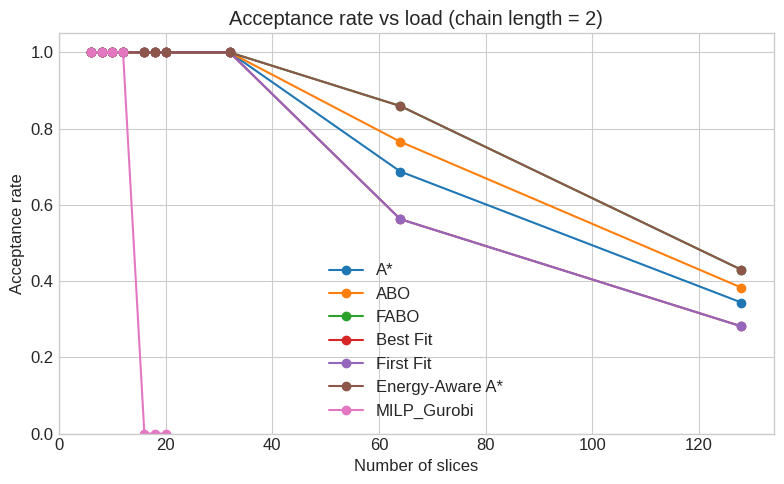

[INFO] Figure saved to: ./results/2025-12-03_08-44-43/fig_acceptance/acceptance_vs_load_vnfs3.png


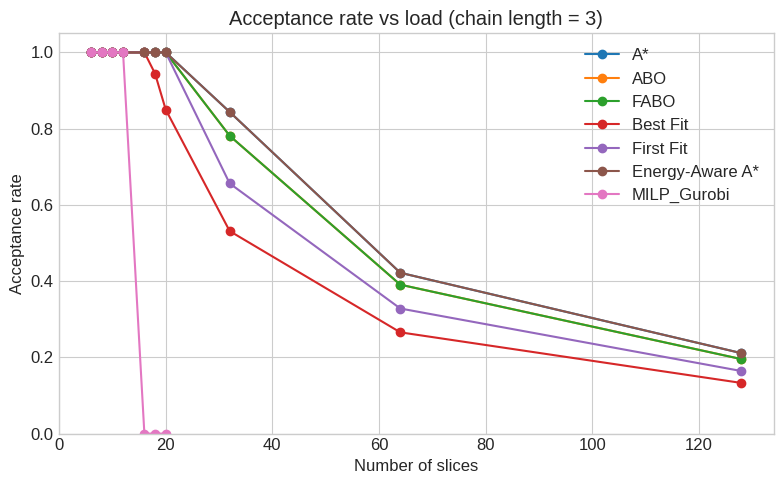

[INFO] Figure saved to: ./results/2025-12-03_08-44-43/fig_acceptance/acceptance_vs_load_vnfs4.png


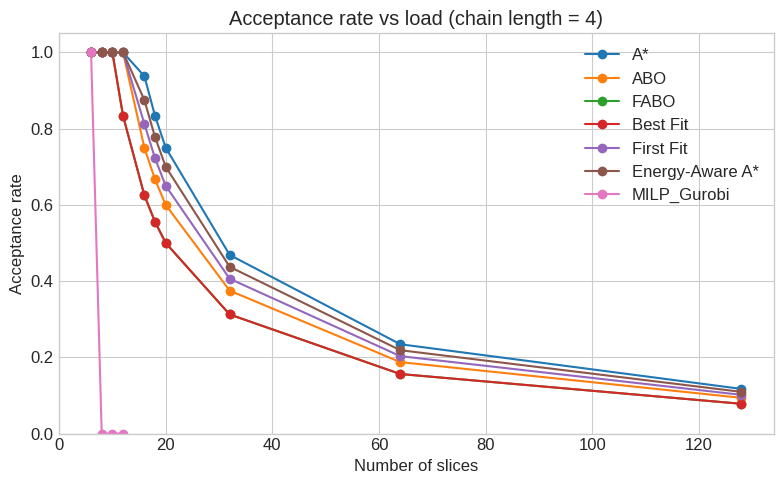

In [9]:
# ===========================================
# Acceptance rate vs number of slices
# for all chain lengths (num_vnfs_per_slice)
# ===========================================
import matplotlib.pyplot as plt
import os

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.size"] = 12

# IMPORTANT: method names must match df_results["method"]
methods_order = [
    "A*",
    "ABO",
    "FABO",
    "Best Fit",
    "First Fit",
    "Energy-Aware A*",
    "MILP_Gurobi",          # <- this is the one used in the run notebook
]

print("[INFO] Methods present in df_results:", df_results["method"].unique())

# Directory to save figures – use latest_dir (where CSV came from)
fig_dir = os.path.join(latest_dir, "fig_acceptance")
os.makedirs(fig_dir, exist_ok=True)

# Loop over all tested chain lengths
for chain_len in sorted(df_results["num_vnfs_per_slice"].unique()):
    mask = df_results["num_vnfs_per_slice"] == chain_len

    fig, ax = plt.subplots()

    for method in methods_order:
        # Skip methods that are not present in df_results
        if method not in df_results["method"].unique():
            continue

        sub = df_results[mask & (df_results["method"] == method)]
        if sub.empty:
            continue

        # Average over seeds for each load level
        grouped = (
            sub.groupby("num_slices")["acceptance_rate"]
            .mean()
            .reset_index()
            .sort_values("num_slices")
        )

        ax.plot(
            grouped["num_slices"],
            grouped["acceptance_rate"],
            marker="o",
            label=method,
        )

    ax.set_xlabel("Number of slices")
    ax.set_ylabel("Acceptance rate")
    ax.set_title(f"Acceptance rate vs load (chain length = {chain_len})")
    ax.set_ylim(0, 1.05)
    ax.legend()
    plt.tight_layout()

    # Save one figure per chain length
    acceptance_fig_path = os.path.join(
        fig_dir, f"acceptance_vs_load_vnfs{chain_len}.png"
    )
    plt.savefig(acceptance_fig_path, dpi=300)
    print(f"[INFO] Figure saved to: {acceptance_fig_path}")

    plt.show()


In [11]:
# ============================
# Load results and add columns
# ============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Base directory where the experiment was saved
base_dir = "./results/2025-12-03_08-44-43"

# Build full path to the CSV file
results_path = os.path.join(base_dir, "scalability_results.csv")
print("[INFO] Loading:", results_path)

df_results = pd.read_csv(results_path)

print("[INFO] df_results shape:", df_results.shape)
print(df_results.head())

# --- Derived metrics ---
df_results["acceptance_rate"] = df_results["accepted"] / df_results["num_slices"]

df_results["energy_per_accepted_slice"] = df_results.apply(
    lambda row: row["total_energy"] / row["accepted"] if row["accepted"] > 0 else np.nan,
    axis=1,
)

df_results["latency_per_accepted_slice"] = df_results.apply(
    lambda row: row["total_latency"] / row["accepted"] if row["accepted"] > 0 else np.nan,
    axis=1,
)

print("\n[INFO] Methods:", df_results["method"].unique())
print("[INFO] num_vnfs_per_slice:", df_results["num_vnfs_per_slice"].unique())


[INFO] Loading: ./results/2025-12-03_08-44-43/scalability_results.csv
[INFO] df_results shape: (990, 11)
             timestamp  num_slices  num_vnfs_per_slice  total_vnfs  seed  \
0  2025-12-03 08:45:03           6                   2          12     1   
1  2025-12-03 08:45:03           6                   2          12     1   
2  2025-12-03 08:45:03           6                   2          12     1   
3  2025-12-03 08:45:03           6                   2          12     1   
4  2025-12-03 08:45:03           6                   2          12     1   

      method  accepted  total_energy  total_bandwidth  total_latency  \
0         A*         6        9.1675            240.0            6.0   
1        ABO         6        4.3650            240.0           12.0   
2       FABO         6       15.0075            240.0           12.0   
3   Best Fit         6        7.1675            240.0            6.0   
4  First Fit         6        7.1675            240.0           18.0   

   ru

In [12]:
df_results["energy_per_accepted_slice"] = df_results.apply(
    lambda row: row["total_energy"] / row["accepted"] if row["accepted"] > 0 else np.nan,
    axis=1,
)


[INFO] Figure saved to: ./results/2025-12-03_08-44-43/fig_energy_per_slice/energy_per_accepted_slice.png


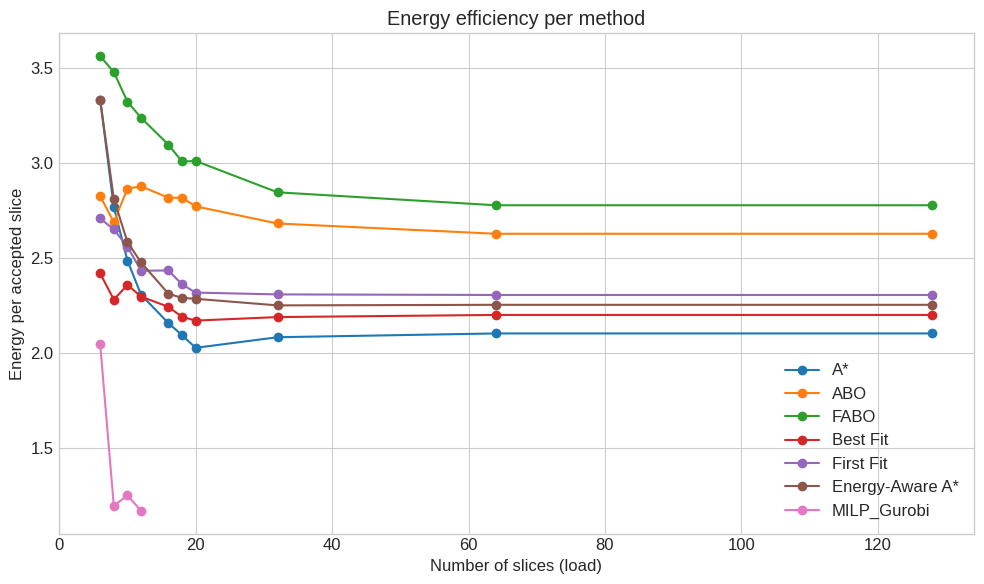

In [13]:
# ============================================
# Energy per accepted slice vs number of slices
# ============================================
import matplotlib.pyplot as plt
import os

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12

# IMPORTANT: match names inside df_results["method"]
methods_order = [
    "A*", "ABO", "FABO",
    "Best Fit", "First Fit",
    "Energy-Aware A*",
    "MILP_Gurobi",   # corrected name
]

fig_dir = os.path.join(latest_dir, "fig_energy_per_slice")
os.makedirs(fig_dir, exist_ok=True)

fig, ax = plt.subplots()

available_methods = df_results["method"].unique()

for method in methods_order:
    if method not in available_methods:
        continue

    sub = df_results[df_results["method"] == method].dropna(subset=["energy_per_accepted_slice"])
    if sub.empty:
        continue
    
    grouped = (
        sub.groupby("num_slices")["energy_per_accepted_slice"]
           .mean()
           .reset_index()
           .sort_values("num_slices")
    )

    ax.plot(
        grouped["num_slices"],
        grouped["energy_per_accepted_slice"],
        marker="o",
        label=method
    )

ax.set_xlabel("Number of slices (load)")
ax.set_ylabel("Energy per accepted slice")
ax.set_title("Energy efficiency per method")
ax.legend()
plt.tight_layout()

fig_path = os.path.join(fig_dir, "energy_per_accepted_slice.png")
plt.savefig(fig_path, dpi=300)
print(f"[INFO] Figure saved to: {fig_path}")

plt.show()


[INFO] Methods in df_results: ['A*' 'ABO' 'FABO' 'Best Fit' 'First Fit' 'Energy-Aware A*' 'MILP_Gurobi']
[INFO] Methods that will be plotted: ['A*', 'ABO', 'FABO', 'Best Fit', 'First Fit', 'Energy-Aware A*', 'MILP_Gurobi']
[INFO] Chain lengths found: [np.int64(2), np.int64(3), np.int64(4)]
[INFO] Figure saved to: ./results/2025-12-03_08-44-43/fig_energy_per_slice_by_chain/energy_per_slice_vs_load_vnfs2.png


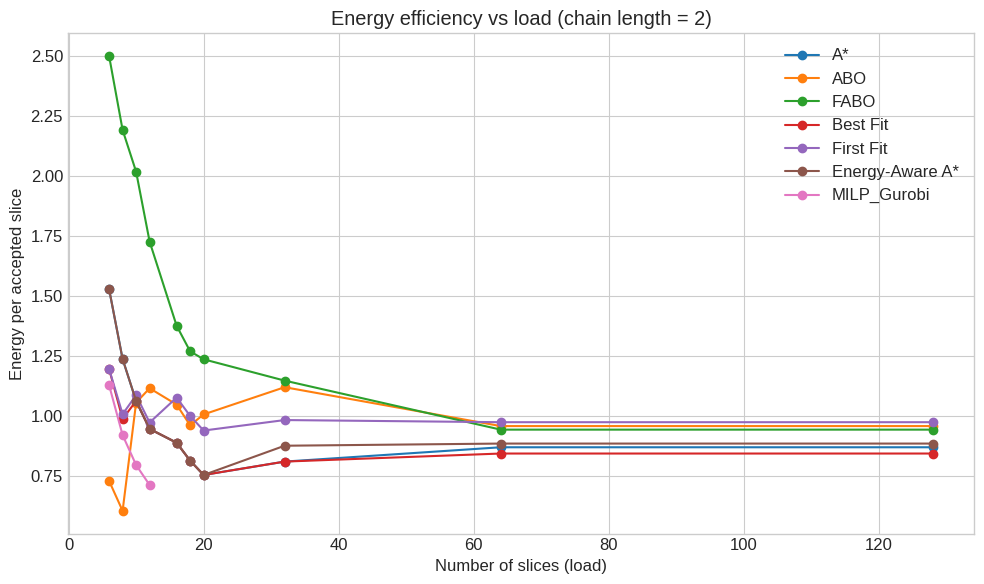

[INFO] Figure saved to: ./results/2025-12-03_08-44-43/fig_energy_per_slice_by_chain/energy_per_slice_vs_load_vnfs3.png


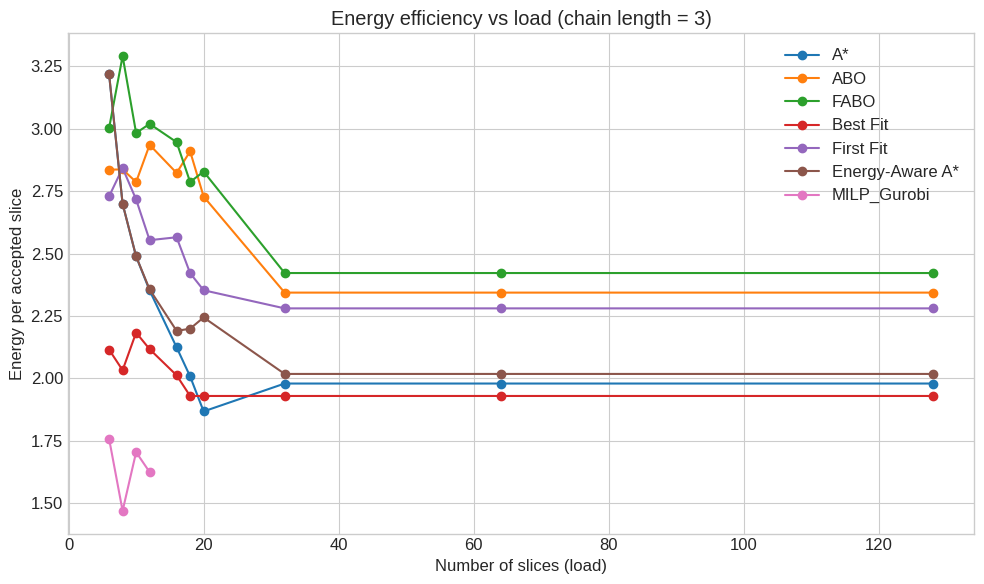

[INFO] Figure saved to: ./results/2025-12-03_08-44-43/fig_energy_per_slice_by_chain/energy_per_slice_vs_load_vnfs4.png


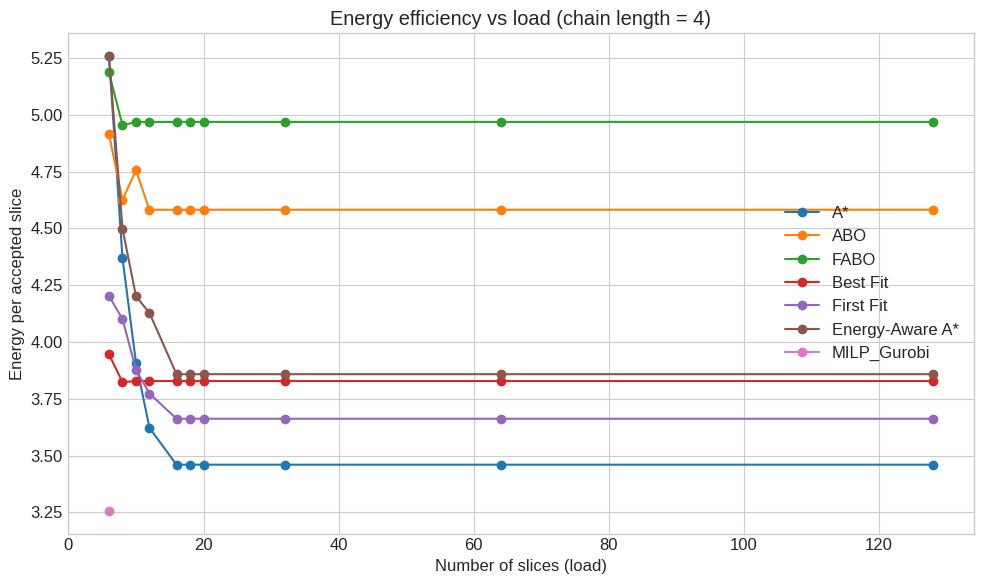

In [14]:
# ============================================
# Energy per accepted slice, split by chain length (2, 3, 4)
# ============================================
import matplotlib.pyplot as plt
import os

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12

# Discover available methods from the data
available_methods = df_results["method"].unique()
print("[INFO] Methods in df_results:", available_methods)

# Base (heuristic) methods we would like to show if present
base_methods = [
    "A*", "ABO", "FABO",
    "Best Fit", "First Fit",
    "Energy-Aware A*",
]

# Add only those base methods that actually exist
methods_order = [m for m in base_methods if m in available_methods]

# Automatically include any MILP-like method (e.g., 'MILP (Gurobi)', 'MILP_Gurobi', etc.)
milp_methods = [m for m in available_methods if "MILP" in m]
methods_order += milp_methods

print("[INFO] Methods that will be plotted:", methods_order)

chain_lengths = sorted(df_results["num_vnfs_per_slice"].unique())
print("[INFO] Chain lengths found:", chain_lengths)

# Directory to save figures -> use latest_dir (where CSV was loaded)
fig_dir = os.path.join(latest_dir, "fig_energy_per_slice_by_chain")
os.makedirs(fig_dir, exist_ok=True)

for chain_len in chain_lengths:
    fig, ax = plt.subplots()

    # Filter by chain length
    mask = df_results["num_vnfs_per_slice"] == chain_len

    for method in methods_order:
        sub = df_results[mask & (df_results["method"] == method)]
        sub = sub.dropna(subset=["energy_per_accepted_slice"])
        if sub.empty:
            continue

        # Average energy per accepted slice over seeds for each load
        grouped = (
            sub.groupby("num_slices")["energy_per_accepted_slice"]
               .mean()
               .reset_index()
               .sort_values("num_slices")
        )

        ax.plot(
            grouped["num_slices"],
            grouped["energy_per_accepted_slice"],
            marker="o",
            label=method
        )

    ax.set_xlabel("Number of slices (load)")
    ax.set_ylabel("Energy per accepted slice")
    ax.set_title(f"Energy efficiency vs load (chain length = {chain_len})")
    ax.legend()
    plt.tight_layout()

    fig_path = os.path.join(fig_dir, f"energy_per_slice_vs_load_vnfs{chain_len}.png")
    plt.savefig(fig_path, dpi=300)
    print(f"[INFO] Figure saved to: {fig_path}")

    plt.show()


In [15]:
summary_var = (
    df_results
    .groupby(["method", "num_slices", "num_vnfs_per_slice"])
    .agg(
        mean_energy=("energy_per_accepted_slice", "mean"),
        std_energy=("energy_per_accepted_slice", "std"),
    )
    .reset_index()
)

summary_var[summary_var["method"] == "ABO"]


method  num_slices  num_vnfs_per_slice  mean_energy  std_energy
30    ABO           6                   2     0.727500         0.0
31    ABO           6                   3     2.836250         0.0
32    ABO           6                   4     4.916042         0.0
33    ABO           8                   2     0.602500         0.0
34    ABO           8                   3     2.837188         0.0
35    ABO           8                   4     4.625469         0.0
36    ABO          10                   2     1.054250         0.0
37    ABO          10                   3     2.786750         0.0
38    ABO          10                   4     4.756250         0.0
39    ABO          12                   2     1.114375         0.0
40    ABO          12                   3     2.935729         0.0
41    ABO          12                   4     4.582500         0.0
42    ABO          16                   2     1.046094         0.0
43    ABO          16                   3     2.823047         0.0
44    ABO          16                   4     4.582500         0.0
45    ABO          18                   2     0.959583         0.0
46    ABO          18                   3     2.909722         0.0
47    ABO          18                   4     4.582500         0.0
48    ABO          20                   2     1.005125         0.0
49    ABO          20                   3     2.728500         0.0
50    ABO          20                   4     4.582500         0.0
51    ABO          32                   2     1.118750         0.0
52    ABO          32                   3     2.343900         0.0
53    ABO          32                   4     4.582500         0.0
54    ABO          64                   2     0.956403         0.0
55    ABO          64                   3     2.343900         0.0
56    ABO          64                   4     4.582500         0.0
57    ABO         128                   2     0.956403         0.0
58    ABO         128                   3     2.343900         0.0
59    ABO         128                   4     4.582500         0.0

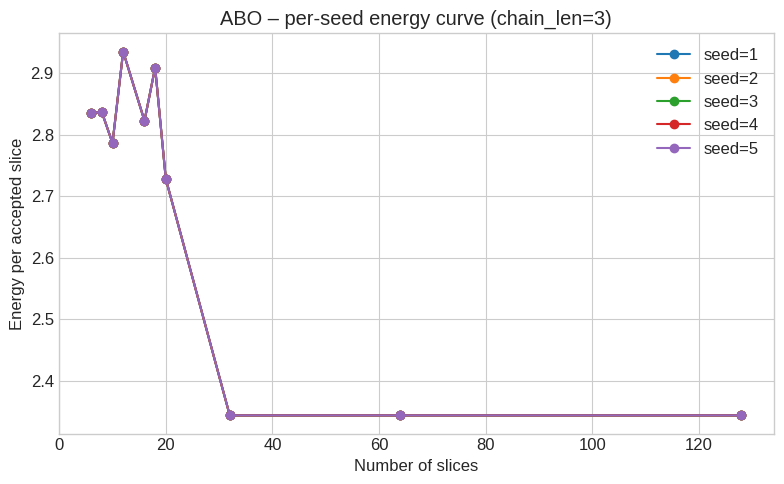

In [16]:
import matplotlib.pyplot as plt

chain_len = 3  # ou 2 / 4
mask = df_results["num_vnfs_per_slice"] == chain_len
abo = df_results[mask & (df_results["method"] == "ABO")]

plt.figure(figsize=(8,5))
for seed in sorted(abo["seed"].unique()):
    sub = abo[abo["seed"] == seed].dropna(subset=["energy_per_accepted_slice"])
    grouped = (
        sub.groupby("num_slices")["energy_per_accepted_slice"]
           .mean()
           .reset_index()
           .sort_values("num_slices")
    )
    plt.plot(grouped["num_slices"], grouped["energy_per_accepted_slice"], marker="o", label=f"seed={seed}")

plt.xlabel("Number of slices")
plt.ylabel("Energy per accepted slice")
plt.title(f"ABO – per-seed energy curve (chain_len={chain_len})")
plt.legend()
plt.tight_layout()
plt.show()


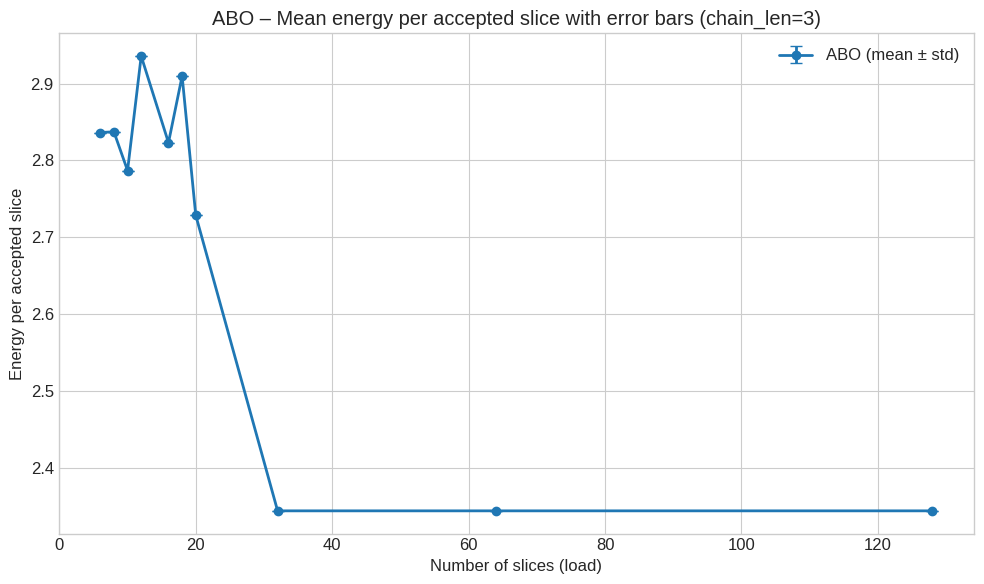

In [23]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12

method = "ABO"
chain_len = 3

# Filtra o dataset
sub = df_results[
    (df_results["method"] == method) &
    (df_results["num_vnfs_per_slice"] == chain_len)
].dropna(subset=["energy_per_accepted_slice"])

if sub.empty:
    print("[ERROR] No data found for this configuration!")
else:
    # Agrupa média e desvio padrão por número de slices
    grouped = (
        sub.groupby("num_slices")["energy_per_accepted_slice"]
           .agg(["mean", "std"])
           .reset_index()
           .sort_values("num_slices")
    )

    x = grouped["num_slices"]
    y = grouped["mean"]
    yerr = grouped["std"]

    # Plot
    plt.errorbar(
        x, y, yerr=yerr,
        marker="o",
        capsize=4,
        linewidth=2,
        markersize=6,
        label=f"{method} (mean ± std)"
    )

    plt.xlabel("Number of slices (load)")
    plt.ylabel("Energy per accepted slice")
    plt.title(f"{method} – Mean energy per accepted slice with error bars (chain_len={chain_len})")
    plt.legend()
    plt.tight_layout()

    plt.show()


In [ ]:
from heuristics.run_abo_full_batch import run_abo_full_batch
from utils.topology import topologie_finlande
from utils.generate_slices import generate_random_slices

G = topologie_finlande()
slices = generate_random_slices()
for seed in [10,20,30,40,50]:
    test = run_abo_full_batch(G, slices, node_capacity_base, link_latency, link_capacity_base)
    print(seed, count_accepted_slices(test[1], slices))


NameError: name 'slices' is not defined

[INFO] FABO – chain lengths found in df_results: [np.int64(2), np.int64(3), np.int64(4)]
[INFO] Figure saved to: ./results/2025-12-03_08-44-43/fig_energy_per_seed_FABO/fabo_per_seed_chainlen2.png


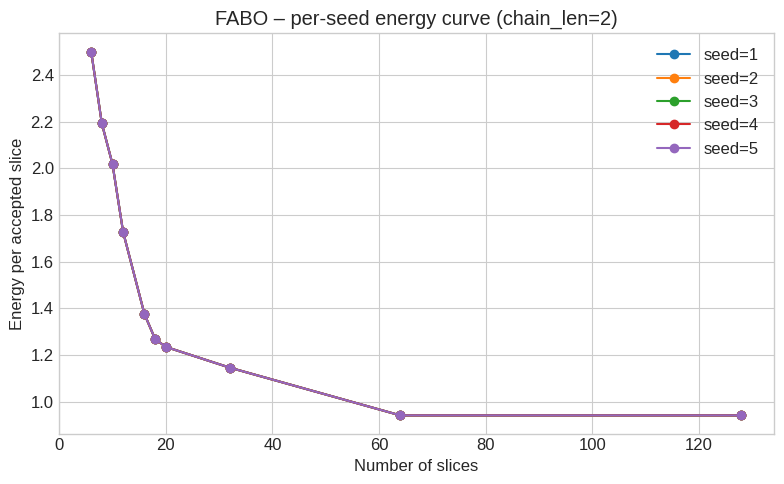

[INFO] Figure saved to: ./results/2025-12-03_08-44-43/fig_energy_per_seed_FABO/fabo_per_seed_chainlen3.png


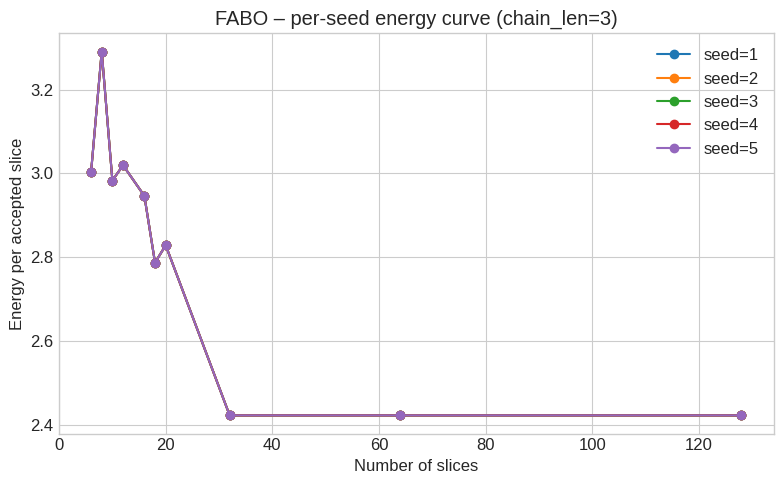

[INFO] Figure saved to: ./results/2025-12-03_08-44-43/fig_energy_per_seed_FABO/fabo_per_seed_chainlen4.png


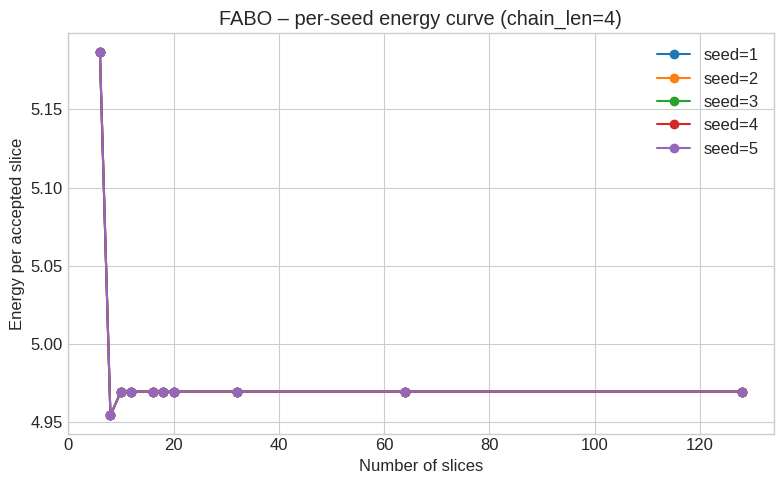

In [17]:
# ============================================
# FABO – per-seed energy curves for each chain length
# ============================================

import os
import matplotlib.pyplot as plt

method = "FABO"  # fixed method name
chain_lengths = sorted(df_results["num_vnfs_per_slice"].unique())

print(f"[INFO] FABO – chain lengths found in df_results: {chain_lengths}")

# Directory to save figures
fig_dir = os.path.join(latest_dir, "fig_energy_per_seed_FABO")
os.makedirs(fig_dir, exist_ok=True)

for chain_len in chain_lengths:
    # Filter rows for this method and chain length
    mask = (
        (df_results["method"] == method) &
        (df_results["num_vnfs_per_slice"] == chain_len)
    )
    sub = df_results[mask].dropna(subset=["energy_per_accepted_slice"])

    if sub.empty:
        print(f"[WARN] No FABO data for chain_len={chain_len}")
        continue

    plt.figure(figsize=(8, 5))

    # Plot one curve per seed
    for seed in sorted(sub["seed"].unique()):
        ssub = sub[sub["seed"] == seed]
        grouped = (
            ssub.groupby("num_slices")["energy_per_accepted_slice"]
                .mean()
                .reset_index()
                .sort_values("num_slices")
        )

        plt.plot(
            grouped["num_slices"],
            grouped["energy_per_accepted_slice"],
            marker="o",
            label=f"seed={seed}"
        )

    plt.xlabel("Number of slices")
    plt.ylabel("Energy per accepted slice")
    plt.title(f"FABO – per-seed energy curve (chain_len={chain_len})")
    plt.legend()
    plt.tight_layout()

    fig_path = os.path.join(fig_dir, f"fabo_per_seed_chainlen{chain_len}.png")
    plt.savefig(fig_path, dpi=300)
    print(f"[INFO] Figure saved to: {fig_path}")

    plt.show()


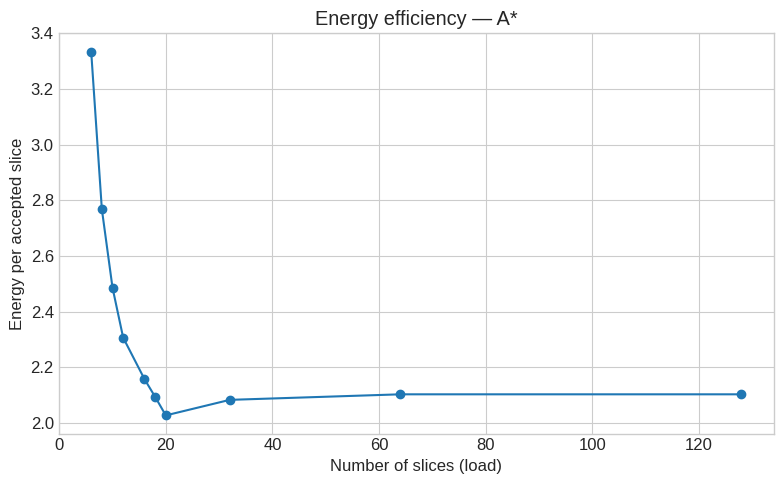

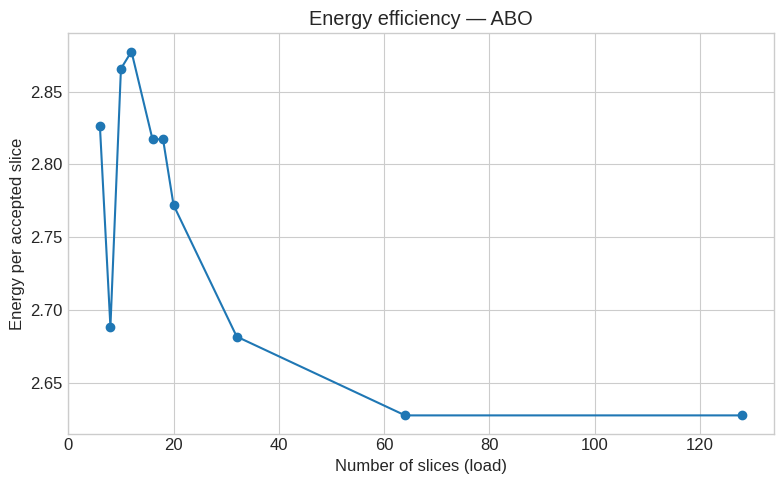

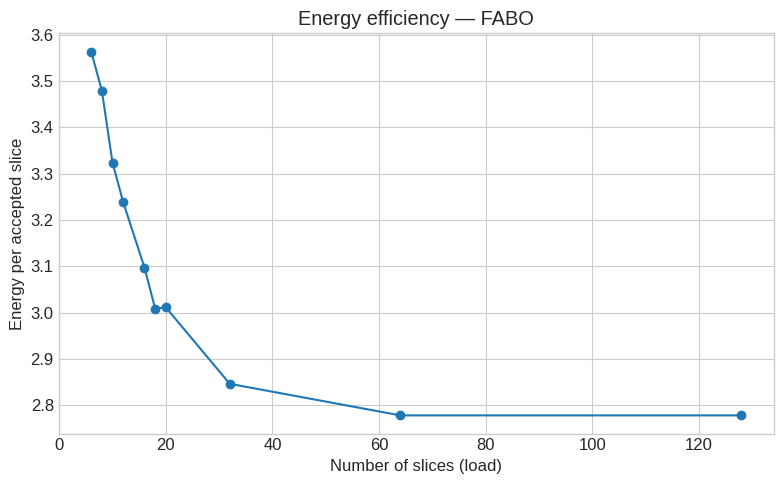

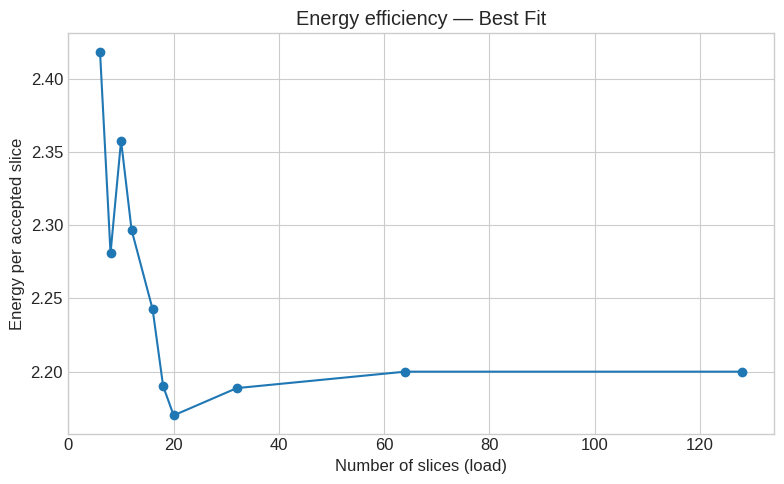

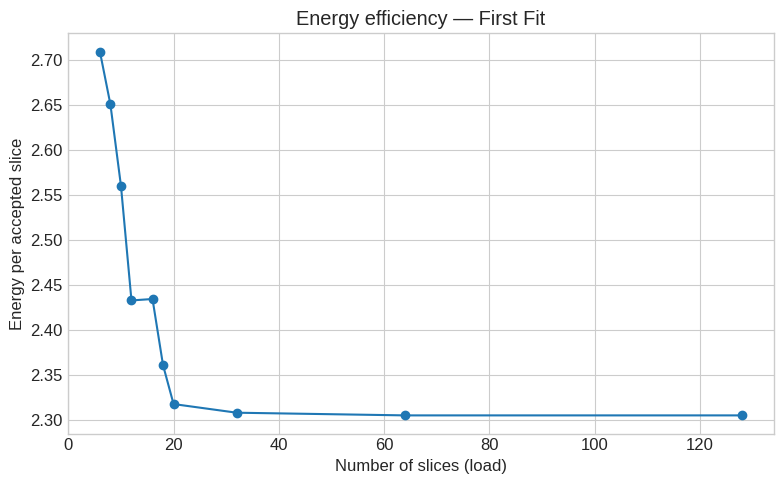

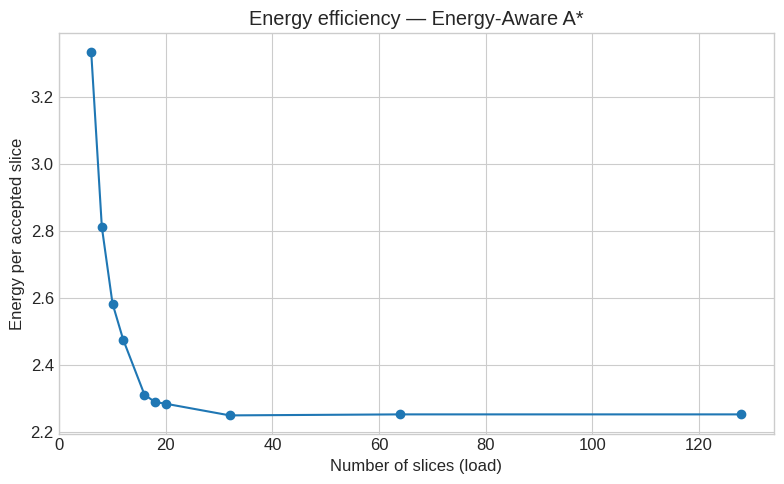

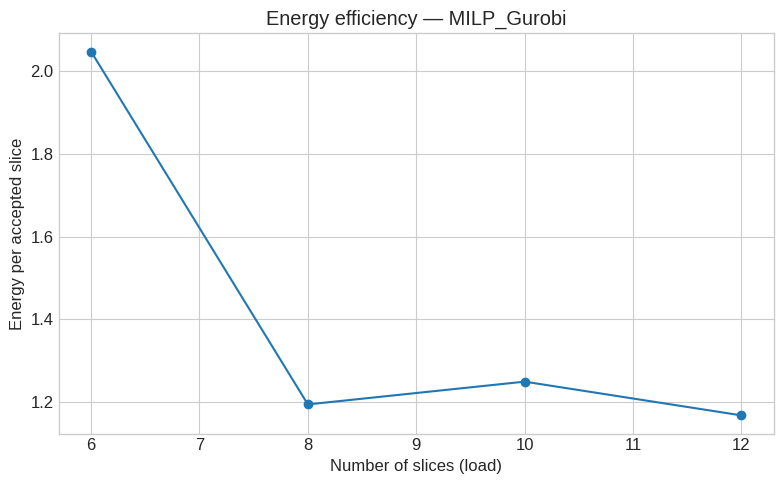

In [18]:
# ============================================
# One plot per method: energy per accepted slice
# ============================================
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

for method in methods_order:
    sub = df_results[df_results["method"] == method]
    sub = sub.dropna(subset=["energy_per_accepted_slice"])
    if sub.empty:
        continue

    grouped = (
        sub.groupby("num_slices")["energy_per_accepted_slice"]
           .mean()
           .reset_index()
           .sort_values("num_slices")
    )
    
    fig, ax = plt.subplots()
    ax.plot(
        grouped["num_slices"],
        grouped["energy_per_accepted_slice"],
        marker="o"
    )
    
    ax.set_xlabel("Number of slices (load)")
    ax.set_ylabel("Energy per accepted slice")
    ax.set_title(f"Energy efficiency — {method}")
    
    plt.tight_layout()
    plt.show()


In [19]:
# ============================================
# Ensure df_results and latest_dir are loaded
# ============================================

import os
import pandas as pd

if "df_results" not in globals() or "latest_dir" not in globals():
    print("[INFO] Loading latest results...")

    root = "./results"
    subdirs = [
        os.path.join(root, d)
        for d in os.listdir(root)
        if os.path.isdir(os.path.join(root, d))
    ]

    if not subdirs:
        raise RuntimeError("No results folders found under ./results")

    latest_dir = max(subdirs, key=os.path.getmtime)
    print("[INFO] Latest results directory:", latest_dir)

    results_path = os.path.join(latest_dir, "scalability_results.csv")
    print("[INFO] Loading:", results_path)

    df_results = pd.read_csv(results_path)

print("[INFO] Loaded df_results:", df_results.shape)


[INFO] Loaded df_results: (990, 14)


[INFO] Methods: ['A*' 'ABO' 'FABO' 'Best Fit' 'First Fit' 'Energy-Aware A*' 'MILP_Gurobi']
[INFO] Methods to plot (with errors): ['A*', 'ABO', 'FABO', 'Best Fit', 'First Fit', 'Energy-Aware A*', 'MILP_Gurobi']
[INFO] Chain lengths: [np.int64(2), np.int64(3), np.int64(4)]
[INFO] Figure saved to: ./results/2025-12-03_08-44-43/fig_energy_mean_with_errorbars/energy_mean_std_chainlen2.png


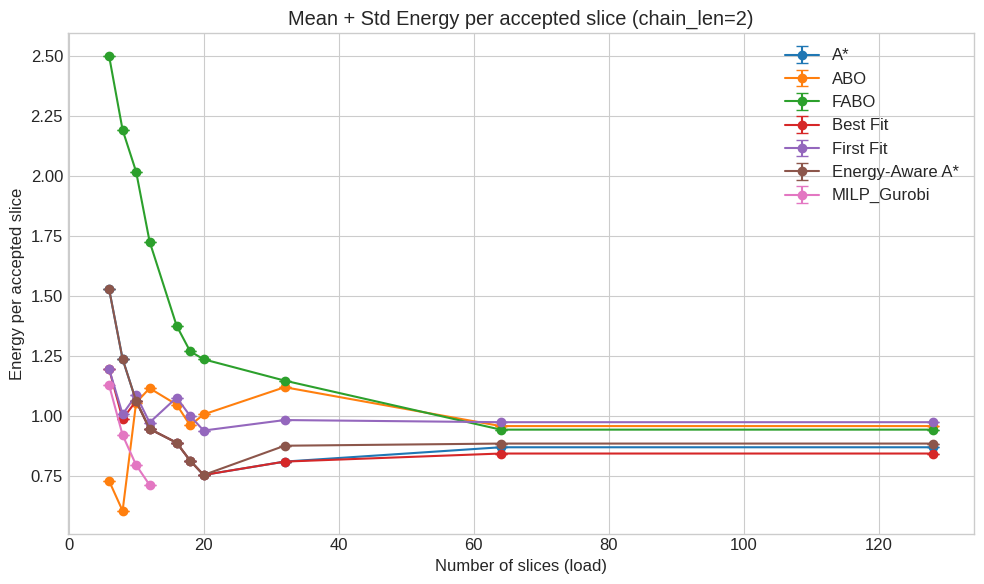

[INFO] Figure saved to: ./results/2025-12-03_08-44-43/fig_energy_mean_with_errorbars/energy_mean_std_chainlen3.png


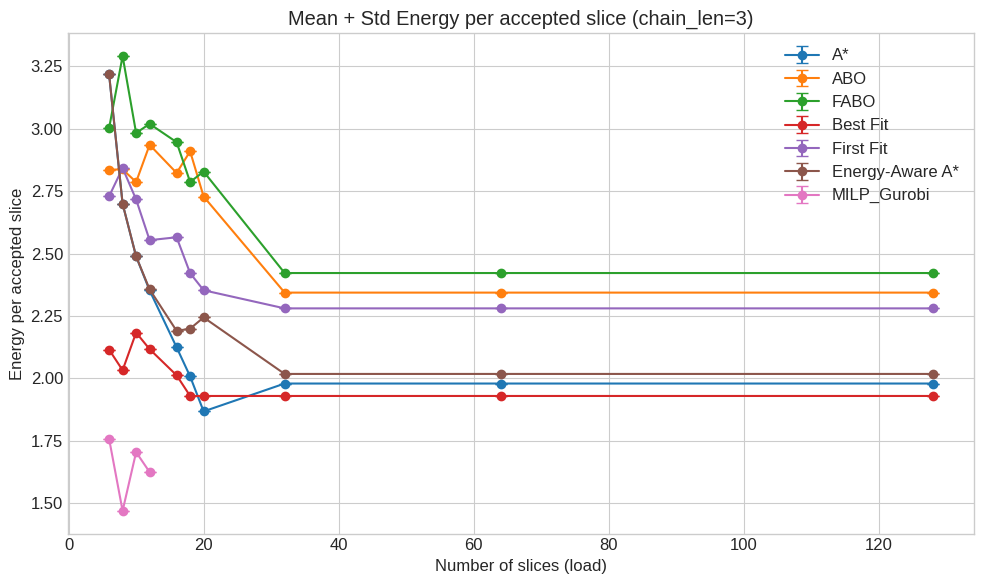

[INFO] Figure saved to: ./results/2025-12-03_08-44-43/fig_energy_mean_with_errorbars/energy_mean_std_chainlen4.png


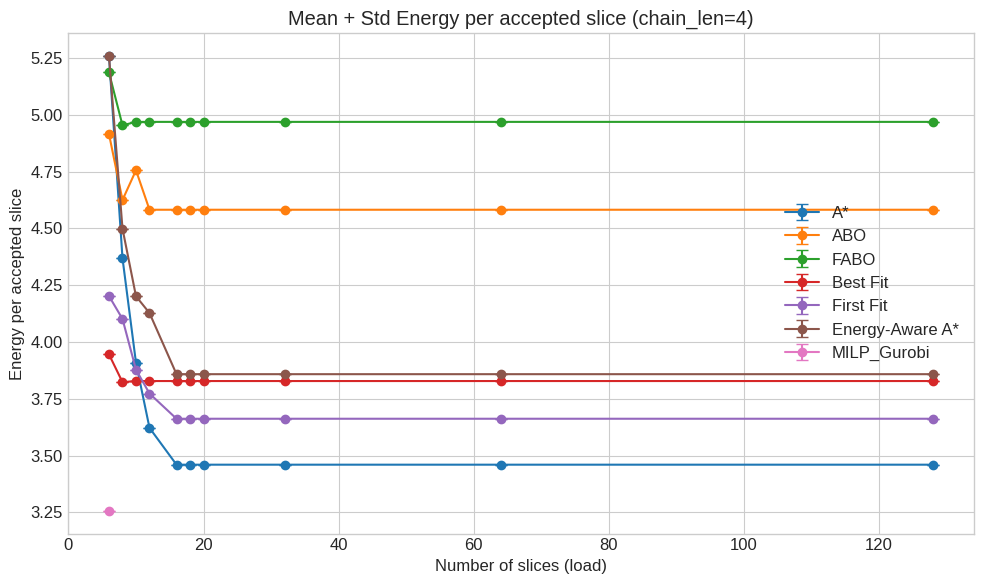

In [20]:
# ============================================
# Mean energy per accepted slice + error bars
# (std across seeds)
# ============================================

import matplotlib.pyplot as plt
import numpy as np
import os

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12

# Determine available methods automatically
available_methods = df_results["method"].unique()
print("[INFO] Methods:", available_methods)

# Preferred plot order
base_methods = [
    "A*", "ABO", "FABO",
    "Best Fit", "First Fit",
    "Energy-Aware A*",
]

# Only keep those that exist in df_results
methods_order = [m for m in base_methods if m in available_methods]

# Add MILP if present
milp_methods = [m for m in available_methods if "MILP" in m]
methods_order += milp_methods

print("[INFO] Methods to plot (with errors):", methods_order)

# Directory to save figures
fig_dir = os.path.join(latest_dir, "fig_energy_mean_with_errorbars")
os.makedirs(fig_dir, exist_ok=True)

chain_lengths = sorted(df_results["num_vnfs_per_slice"].unique())
print("[INFO] Chain lengths:", chain_lengths)

for chain_len in chain_lengths:
    plt.figure(figsize=(10, 6))

    mask = df_results["num_vnfs_per_slice"] == chain_len

    for method in methods_order:
        sub = df_results[mask & (df_results["method"] == method)]
        sub = sub.dropna(subset=["energy_per_accepted_slice"])

        if sub.empty:
            continue

        grouped = (
            sub.groupby("num_slices")["energy_per_accepted_slice"]
               .agg(["mean", "std"])
               .reset_index()
               .sort_values("num_slices")
        )

        x = grouped["num_slices"]
        y = grouped["mean"]
        yerr = grouped["std"]  # use std as error bar

        plt.errorbar(
            x, y, yerr=yerr,
            marker="o",
            capsize=4,
            label=method
        )

    plt.xlabel("Number of slices (load)")
    plt.ylabel("Energy per accepted slice")
    plt.title(f"Mean + Std Energy per accepted slice (chain_len={chain_len})")
    plt.legend()
    plt.tight_layout()

    # Save figure
    fig_path = os.path.join(fig_dir, f"energy_mean_std_chainlen{chain_len}.png")
    plt.savefig(fig_path, dpi=300)
    print(f"[INFO] Figure saved to: {fig_path}")

    plt.show()


NameError: name 'results_dir' is not defined

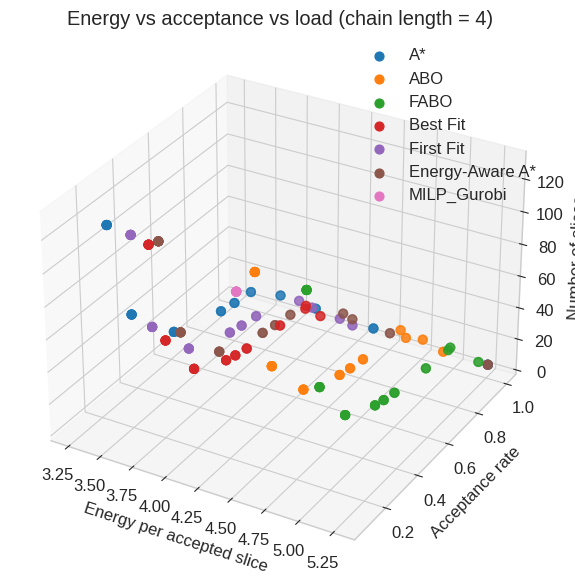

In [21]:
# ===========================================
# 3D plot: energy per accepted slice vs acceptance vs load
# ===========================================
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

df_3d = df_results.copy()
df_3d = df_3d.dropna(subset=["energy_per_accepted_slice"])

# Optional: focus on one chain length
chain_len = 4
df_3d = df_3d[df_3d["num_vnfs_per_slice"] == chain_len]

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection="3d")

for method in methods_order:
    sub = df_3d[df_3d["method"] == method]
    if sub.empty:
        continue

    ax.scatter(
        sub["energy_per_accepted_slice"],
        sub["acceptance_rate"],
        sub["num_slices"],
        label=method,
        s=40,
    )

ax.set_xlabel("Energy per accepted slice")
ax.set_ylabel("Acceptance rate")
ax.set_zlabel("Number of slices")
ax.set_title(f"Energy vs acceptance vs load (chain length = {chain_len})")
ax.legend()
plt.tight_layout()

fig3d_path = os.path.join(results_dir, f"3d_energy_acceptance_vnfs{chain_len}.png")
plt.savefig(fig3d_path, dpi=300)
print(f"[INFO] 3D figure saved to: {fig3d_path}")

plt.show()


In [ ]:
# ===========================================
# Quick peek: best energy per scenario (same acceptance)
# ===========================================
cols = ["method", "num_slices", "num_vnfs_per_slice", "seed",
        "accepted", "acceptance_rate", "total_energy", "energy_per_accepted_slice"]

sample = (
    df_results[cols]
    .sort_values(["num_slices", "num_vnfs_per_slice", "seed",
                  "acceptance_rate", "total_energy"])
    .groupby(["num_slices", "num_vnfs_per_slice", "seed", "acceptance_rate"])
    .first()
    .reset_index()
)

display(sample.head(30))


num_slices  num_vnfs_per_slice  seed  acceptance_rate         method  \
0            4                   2     1              1.0            ABO   
1            4                   2     2              1.0            ABO   
2            4                   2     3              1.0            ABO   
3            4                   2     4              1.0            ABO   
4            4                   2     5              1.0            ABO   
5            4                   3     1              1.0       Best Fit   
6            4                   3     2              1.0       Best Fit   
7            4                   3     3              1.0       Best Fit   
8            4                   3     4              1.0       Best Fit   
9            4                   3     5              1.0       Best Fit   
10           4                   4     1              1.0  MILP (Gurobi)   
11           4                   4     2              1.0  MILP (Gurobi)   
12           4                   4     3              1.0  MILP (Gurobi)   
13           4                   4     4              1.0  MILP (Gurobi)   
14           4                   4     5              1.0  MILP (Gurobi)   
15           6                   2     1              1.0            ABO   
16           6                   2     2              1.0            ABO   
17           6                   2     3              1.0            ABO   
18           6                   2     4              1.0            ABO   
19           6                   2     5              1.0            ABO   
20           6                   3     1              1.0  MILP (Gurobi)   
21           6                   3     2              1.0  MILP (Gurobi)   
22           6                   3     3              1.0  MILP (Gurobi)   
23           6                   3     4              1.0  MILP (Gurobi)   
24           6                   3     5              1.0  MILP (Gurobi)   
25           6                   4     1              1.0  MILP (Gurobi)   
26           6                   4     2              1.0  MILP (Gurobi)   
27           6                   4     3              1.0  MILP (Gurobi)   
28           6                   4     4              1.0  MILP (Gurobi)   
29           6                   4     5              1.0  MILP (Gurobi)   

    accepted  total_energy  energy_per_accepted_slice  
0          4        3.9100                   0.977500  
1          4        3.9100                   0.977500  
2          4        3.9100                   0.977500  
3          4        3.9100                   0.977500  
4          4        3.9100                   0.977500  
5          4        7.0200                   1.755000  
6          4        7.0200                   1.755000  
7          4        7.0200                   1.755000  
8          4        7.0200                   1.755000  
9          4        7.0200                   1.755000  
10         4       14.6050                   3.651250  
11         4       14.6050                   3.651250  
12         4       14.6050                   3.651250  
13         4       14.6050                   3.651250  
14         4       14.6050                   3.651250  
15         6        4.3650                   0.727500  
16         6        4.3650                   0.727500  
17         6        4.3650                   0.727500  
18         6        4.3650                   0.727500  
19         6        4.3650                   0.727500  
20         6       10.5500                   1.758333  
21         6       10.5500                   1.758333  
22         6       10.5500                   1.758333  
23         6       10.5500                   1.758333  
24         6       10.5500                   1.758333  
25         6       19.5375                   3.256250  
26         6       19.5375                   3.256250  
27         6       19.5375                   3.256250  
28         6       19.5